# **Image Caption Generator**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
BASE_DIR = '/content/drive/MyDrive/aml_project'
WORKING_DIR = '/content/drive/MyDrive/features'

In [ ]:
# load the model
model = InceptionV3()

# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


**Extract Image features**

In [ ]:
# Extract features from images
features = {}
directory = '/content/drive/MyDrive/aml_project/Images'

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)  # Use os.path.join for better compatibility
    image = load_img(img_path, target_size=(299, 299))  # Change target size to (299, 299)

    # Convert image pixels to numpy array
    image = img_to_array(image)

    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess image for VGG (or whichever model you are using)
    image = preprocess_input(image)

    # Extract features
    feature = model.predict(image, verbose=0)

    # Get image ID
    image_id = img_name.split('.')[0]

    # Store feature
    features[image_id] = feature


  0%|          | 0/8101 [00:00<?, ?it/s]

In [ ]:
# store features
pickle.dump(features,open(os.path.join(WORKING_DIR,'features1.pkl'),'wb'))

In [ ]:
#load features from pickle
with open(os.path.join(WORKING_DIR,'features1.pkl'),'rb') as f:
  features=pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR,'captions.txt')) as f:
  next(f)
  captions_doc=f.read()

**LOAD THE CAPTIONS DATA**

In [ ]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id, caption=tokens[0],tokens[1:]
  image_id=image_id.split('.')[0]
  caption=" ".join(caption)
  if image_id not in mapping :
    mapping[image_id]=[]
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

**PREPROCESS TEXT DATA**

In [ ]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
def clean(mapping):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      caption=captions[i]
      caption=caption.lower()
      caption=caption.replace('[^A-Za-z]','')
      caption=caption.replace('\s+',' ')
      caption='startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
      captions[i]=caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**NEXT WE STORE THE PREPROCESS TEXT INTO THE LIST**

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

**NOW WE START PROCESS THE TEXT DATA**

In [ ]:
# TOKENIZING THE TEXT
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1


In [ ]:
vocab_size

8485

In [ ]:
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'red': 24,
 'young': 25,
 'brown': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'shirt': 35,
 'down': 36,
 'standing': 37,
 'ball': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'front': 47,
 'sitting': 48,
 'holding': 49,
 'up': 50,
 'field': 51,
 'small': 52,
 'by': 53,
 'a': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [ ]:
# get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

Train Test Split

In [ ]:
##After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]



Now we will define a batch and include the padding sequence

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

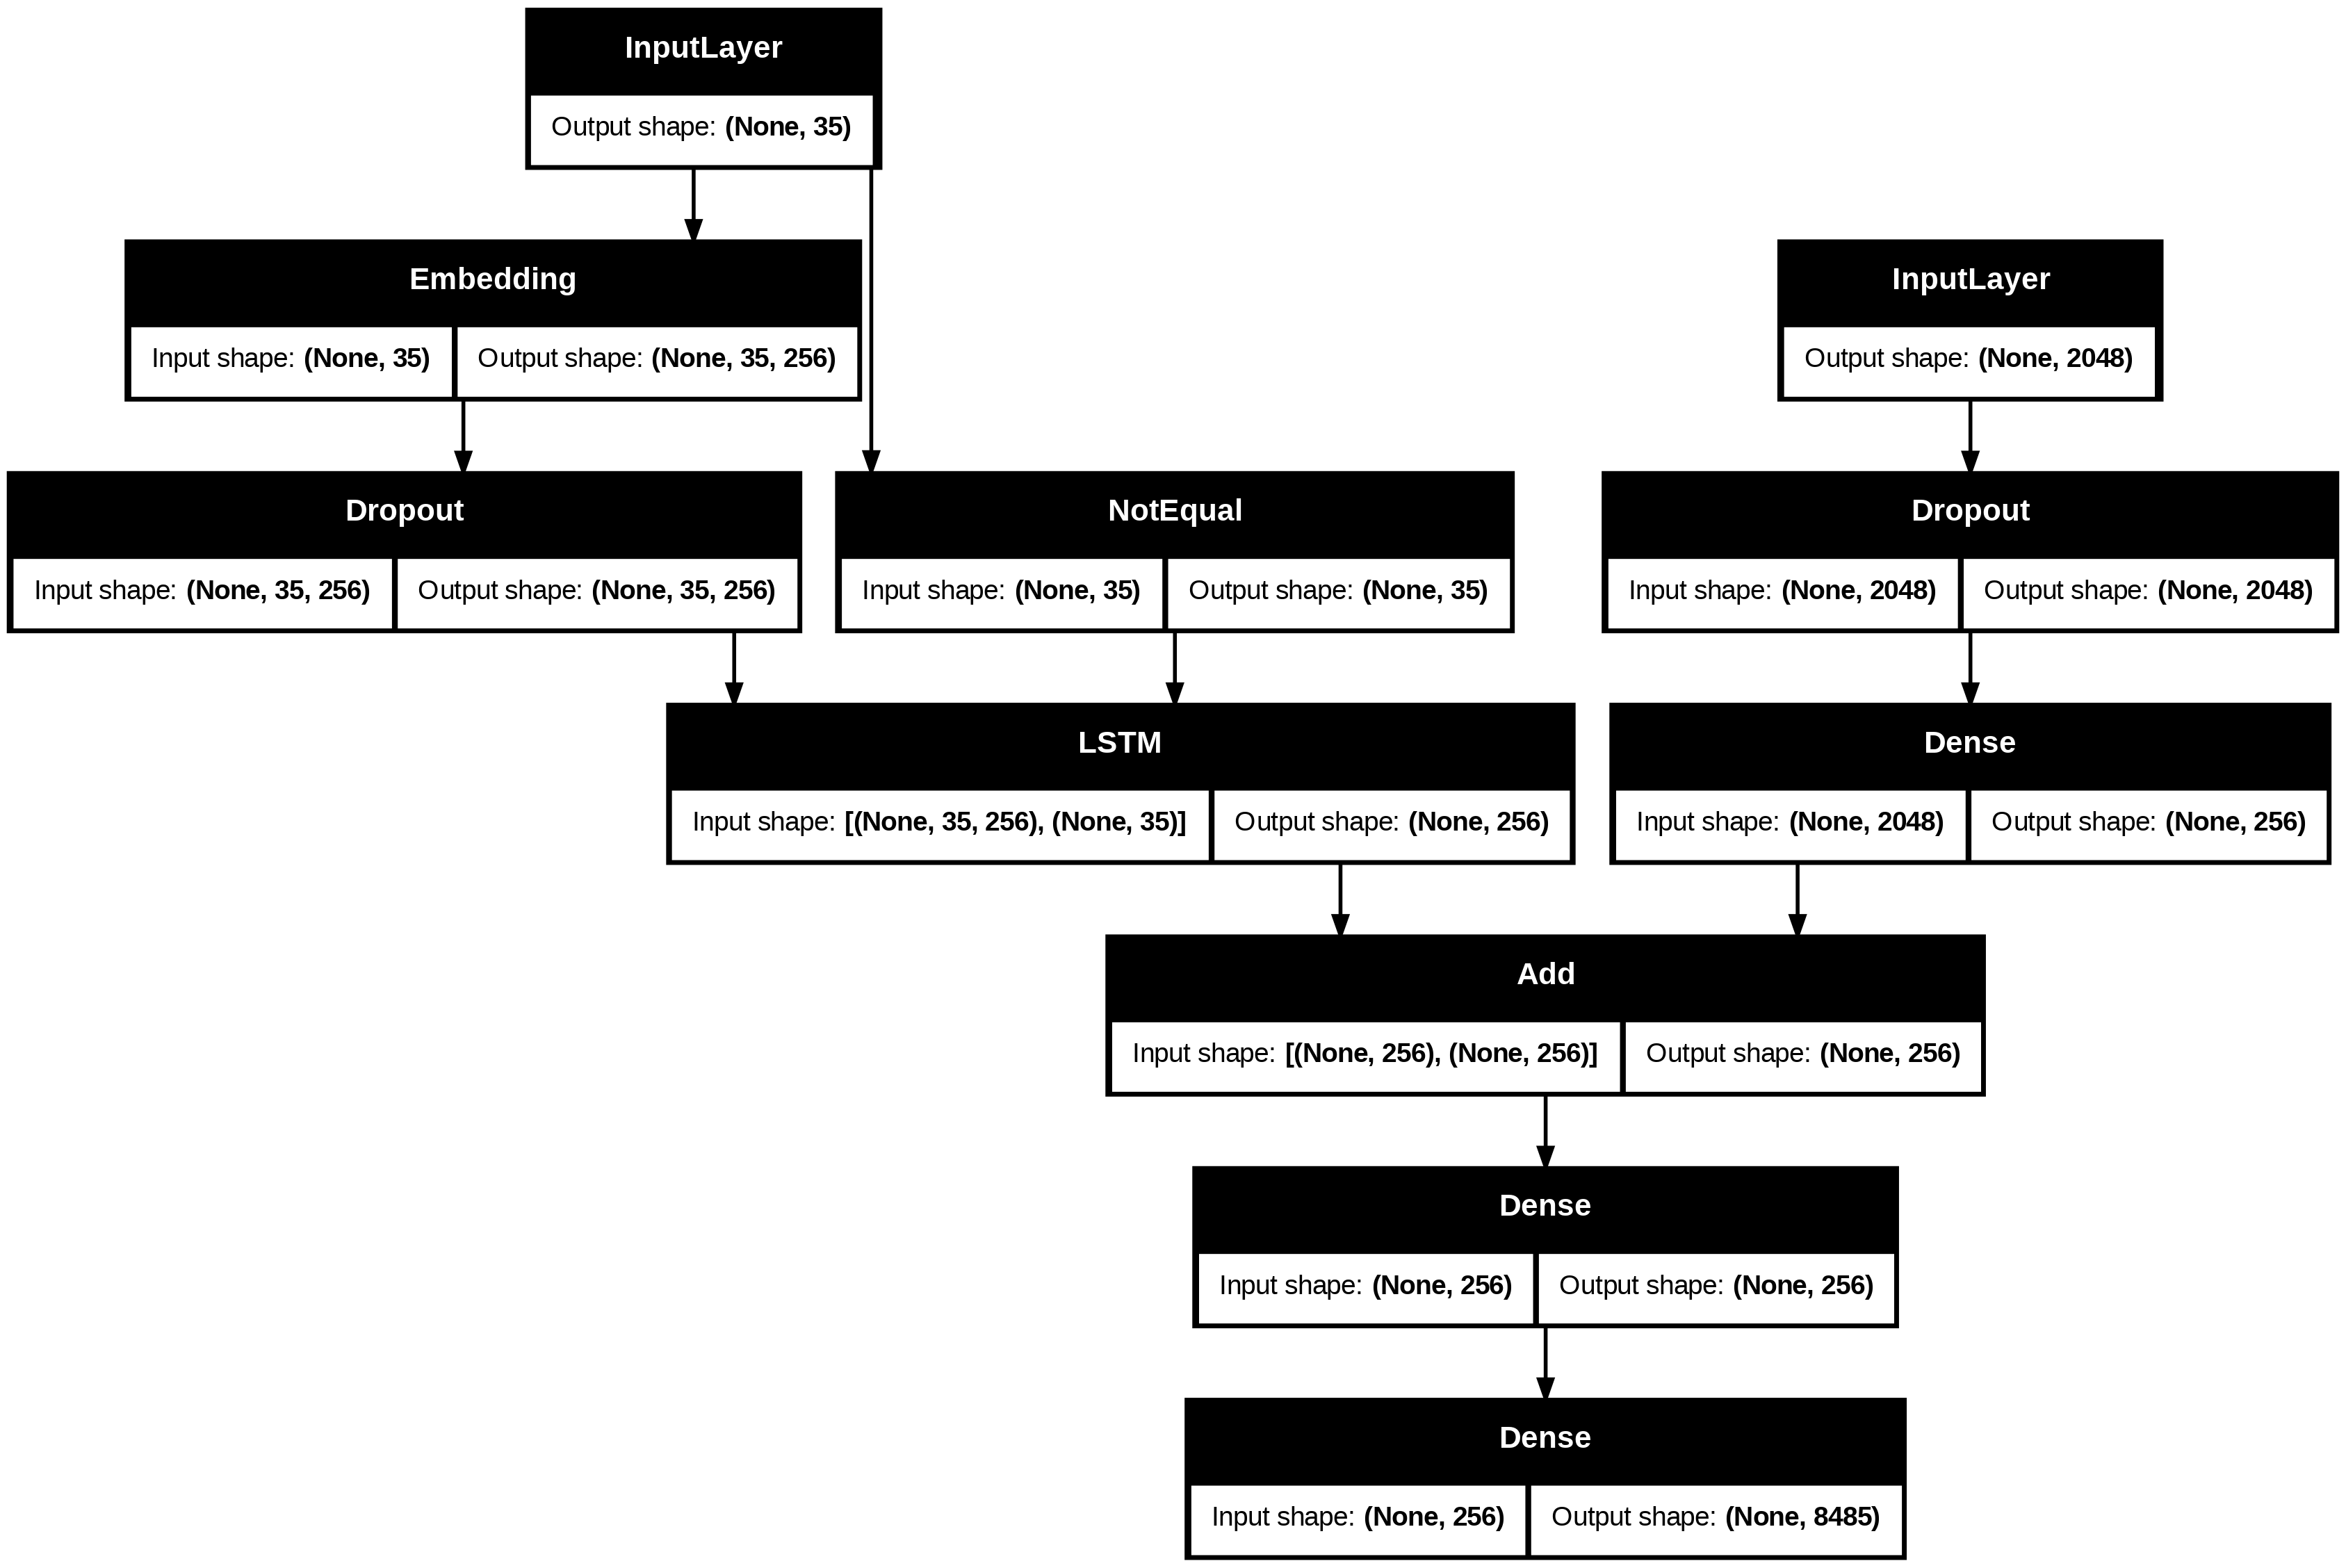

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Now let us train the model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - loss: 5.9487
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 4.1641
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 3.6861
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 3.4216
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 3.2417
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 3.1063
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.9927
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.8946
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.8148
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 270ms/step - loss: 2.7365
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.6711
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.6115
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - loss: 2.5556
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - loss: 2.5052
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.4570
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - loss: 2.4139
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - loss: 2.37

You can save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/inception_model_1.h5')

Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


Now we validate the data using BLEU Score

  0%|          | 0/810 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

BLEU-1: 0.444444
BLEU-2: 0.000000


  0%|          | 2/810 [00:01<09:59,  1.35it/s]

BLEU-1: 0.529412
BLEU-2: 0.265684


  0%|          | 3/810 [00:02<14:31,  1.08s/it]

BLEU-1: 0.441176
BLEU-2: 0.206626


  0%|          | 4/810 [00:04<15:34,  1.16s/it]

BLEU-1: 0.395833
BLEU-2: 0.164282


  1%|          | 5/810 [00:05<14:29,  1.08s/it]

BLEU-1: 0.375000
BLEU-2: 0.138086


  1%|          | 6/810 [00:06<13:23,  1.00it/s]

BLEU-1: 0.423077
BLEU-2: 0.171407


  1%|          | 7/810 [00:06<10:57,  1.22it/s]

BLEU-1: 0.418605
BLEU-2: 0.162770


  1%|          | 8/810 [00:07<09:56,  1.35it/s]

BLEU-1: 0.427083
BLEU-2: 0.170644


  1%|          | 9/810 [00:07<09:12,  1.45it/s]

BLEU-1: 0.424528
BLEU-2: 0.175032


  1%|          | 10/810 [00:08<08:13,  1.62it/s]

BLEU-1: 0.456140
BLEU-2: 0.187317


  1%|▏         | 11/810 [00:08<07:47,  1.71it/s]

BLEU-1: 0.479675
BLEU-2: 0.217050


  1%|▏         | 12/810 [00:09<08:03,  1.65it/s]

BLEU-1: 0.485075
BLEU-2: 0.209132


  2%|▏         | 13/810 [00:09<07:23,  1.80it/s]

BLEU-1: 0.492958
BLEU-2: 0.222885


  2%|▏         | 14/810 [00:10<07:53,  1.68it/s]

BLEU-1: 0.483660
BLEU-2: 0.212684


  2%|▏         | 15/810 [00:10<07:35,  1.74it/s]

BLEU-1: 0.475309
BLEU-2: 0.205022


  2%|▏         | 16/810 [00:11<07:21,  1.80it/s]

BLEU-1: 0.482353
BLEU-2: 0.216754


  2%|▏         | 17/810 [00:12<07:31,  1.76it/s]

BLEU-1: 0.502793
BLEU-2: 0.229700


  2%|▏         | 18/810 [00:12<07:56,  1.66it/s]

BLEU-1: 0.505181
BLEU-2: 0.247049


  2%|▏         | 19/810 [00:13<08:00,  1.65it/s]

BLEU-1: 0.499901
BLEU-2: 0.238435


  2%|▏         | 20/810 [00:14<09:30,  1.39it/s]

BLEU-1: 0.506763
BLEU-2: 0.262438


  3%|▎         | 21/810 [00:15<10:44,  1.22it/s]

BLEU-1: 0.499880
BLEU-2: 0.257807


  3%|▎         | 22/810 [00:16<10:12,  1.29it/s]

BLEU-1: 0.506204
BLEU-2: 0.264751


  3%|▎         | 23/810 [00:16<10:37,  1.23it/s]

BLEU-1: 0.515894
BLEU-2: 0.274113


  3%|▎         | 24/810 [00:17<09:46,  1.34it/s]

BLEU-1: 0.513319
BLEU-2: 0.268814


  3%|▎         | 25/810 [00:18<09:04,  1.44it/s]

BLEU-1: 0.512804
BLEU-2: 0.268820


  3%|▎         | 26/810 [00:18<08:06,  1.61it/s]

BLEU-1: 0.519639
BLEU-2: 0.278329


  3%|▎         | 27/810 [00:19<09:02,  1.44it/s]

BLEU-1: 0.511410
BLEU-2: 0.267204


  3%|▎         | 28/810 [00:20<09:15,  1.41it/s]

BLEU-1: 0.517610
BLEU-2: 0.277253


  4%|▎         | 29/810 [00:21<10:31,  1.24it/s]

BLEU-1: 0.520161
BLEU-2: 0.278065


  4%|▎         | 30/810 [00:22<10:27,  1.24it/s]

BLEU-1: 0.530180
BLEU-2: 0.288483


  4%|▍         | 31/810 [00:22<09:32,  1.36it/s]

BLEU-1: 0.535177
BLEU-2: 0.291594


  4%|▍         | 32/810 [00:23<09:25,  1.38it/s]

BLEU-1: 0.532437
BLEU-2: 0.291147


  4%|▍         | 33/810 [00:23<09:07,  1.42it/s]

BLEU-1: 0.537088
BLEU-2: 0.288361


  4%|▍         | 34/810 [00:25<11:13,  1.15it/s]

BLEU-1: 0.534390
BLEU-2: 0.284255


  4%|▍         | 35/810 [00:25<10:20,  1.25it/s]

BLEU-1: 0.539844
BLEU-2: 0.294866


  4%|▍         | 36/810 [00:26<10:07,  1.27it/s]

BLEU-1: 0.539799
BLEU-2: 0.297512


  5%|▍         | 37/810 [00:27<10:03,  1.28it/s]

BLEU-1: 0.538455
BLEU-2: 0.296860


  5%|▍         | 38/810 [00:28<10:13,  1.26it/s]

BLEU-1: 0.543122
BLEU-2: 0.300515


  5%|▍         | 39/810 [00:28<09:41,  1.33it/s]

BLEU-1: 0.543578
BLEU-2: 0.300613


  5%|▍         | 40/810 [00:29<09:36,  1.34it/s]

BLEU-1: 0.548315
BLEU-2: 0.305641


  5%|▌         | 41/810 [00:30<09:49,  1.30it/s]

BLEU-1: 0.555066
BLEU-2: 0.315365


  5%|▌         | 42/810 [00:31<09:42,  1.32it/s]

BLEU-1: 0.558184
BLEU-2: 0.315032


  5%|▌         | 43/810 [00:32<11:48,  1.08it/s]

BLEU-1: 0.555788
BLEU-2: 0.312727


  5%|▌         | 44/810 [00:33<10:43,  1.19it/s]

BLEU-1: 0.553493
BLEU-2: 0.312593


  6%|▌         | 45/810 [00:33<09:15,  1.38it/s]

BLEU-1: 0.551505
BLEU-2: 0.311251


  6%|▌         | 46/810 [00:33<08:13,  1.55it/s]

BLEU-1: 0.552674
BLEU-2: 0.313073


  6%|▌         | 47/810 [00:34<07:32,  1.68it/s]

BLEU-1: 0.555763
BLEU-2: 0.317287


  6%|▌         | 48/810 [00:34<06:57,  1.82it/s]

BLEU-1: 0.557911
BLEU-2: 0.319571


  6%|▌         | 49/810 [00:36<09:04,  1.40it/s]

BLEU-1: 0.558052
BLEU-2: 0.320009


  6%|▌         | 50/810 [00:36<08:48,  1.44it/s]

BLEU-1: 0.565138
BLEU-2: 0.324092


  6%|▋         | 51/810 [00:37<08:25,  1.50it/s]

BLEU-1: 0.564982
BLEU-2: 0.323203


  6%|▋         | 52/810 [00:37<07:24,  1.71it/s]

BLEU-1: 0.566845
BLEU-2: 0.325263


  7%|▋         | 53/810 [00:38<07:41,  1.64it/s]

BLEU-1: 0.566434
BLEU-2: 0.323688


  7%|▋         | 54/810 [00:39<08:17,  1.52it/s]

BLEU-1: 0.567521
BLEU-2: 0.323636


  7%|▋         | 55/810 [00:39<07:34,  1.66it/s]

BLEU-1: 0.568297
BLEU-2: 0.323381


  7%|▋         | 56/810 [00:40<07:04,  1.78it/s]

BLEU-1: 0.570715
BLEU-2: 0.328420


  7%|▋         | 57/810 [00:40<06:42,  1.87it/s]

BLEU-1: 0.568852
BLEU-2: 0.325531


  7%|▋         | 58/810 [00:41<06:38,  1.89it/s]

BLEU-1: 0.572815
BLEU-2: 0.330858


  7%|▋         | 59/810 [00:41<07:52,  1.59it/s]

BLEU-1: 0.568938
BLEU-2: 0.326232


  7%|▋         | 60/810 [00:42<08:21,  1.49it/s]

BLEU-1: 0.565421
BLEU-2: 0.323919


  8%|▊         | 61/810 [00:43<08:25,  1.48it/s]

BLEU-1: 0.570769
BLEU-2: 0.330911


  8%|▊         | 62/810 [00:44<08:58,  1.39it/s]

BLEU-1: 0.573596
BLEU-2: 0.333845


  8%|▊         | 63/810 [00:45<10:30,  1.18it/s]

BLEU-1: 0.574405
BLEU-2: 0.336427


  8%|▊         | 64/810 [00:45<09:43,  1.28it/s]

BLEU-1: 0.572901
BLEU-2: 0.335734


  8%|▊         | 65/810 [00:47<11:28,  1.08it/s]

BLEU-1: 0.575540
BLEU-2: 0.337927


  8%|▊         | 66/810 [00:47<10:00,  1.24it/s]

BLEU-1: 0.573864
BLEU-2: 0.335312


  8%|▊         | 67/810 [00:48<10:08,  1.22it/s]

BLEU-1: 0.570432
BLEU-2: 0.331208


  8%|▊         | 68/810 [00:49<10:47,  1.15it/s]

BLEU-1: 0.566940
BLEU-2: 0.327997


  9%|▊         | 69/810 [00:50<10:06,  1.22it/s]

BLEU-1: 0.569314
BLEU-2: 0.332645


  9%|▊         | 70/810 [00:51<10:14,  1.20it/s]

BLEU-1: 0.566711
BLEU-2: 0.332472


  9%|▉         | 71/810 [00:51<08:52,  1.39it/s]

BLEU-1: 0.568627
BLEU-2: 0.335038


  9%|▉         | 72/810 [00:52<08:36,  1.43it/s]

BLEU-1: 0.573454
BLEU-2: 0.342487


  9%|▉         | 73/810 [00:53<09:47,  1.25it/s]

BLEU-1: 0.576293
BLEU-2: 0.344180


  9%|▉         | 74/810 [00:53<08:38,  1.42it/s]

BLEU-1: 0.579276
BLEU-2: 0.349157


  9%|▉         | 75/810 [00:54<08:46,  1.40it/s]

BLEU-1: 0.581796
BLEU-2: 0.354043


  9%|▉         | 76/810 [00:54<07:54,  1.55it/s]

BLEU-1: 0.582217
BLEU-2: 0.354713


 10%|▉         | 77/810 [00:55<08:02,  1.52it/s]

BLEU-1: 0.580529
BLEU-2: 0.354024


 10%|▉         | 78/810 [00:56<08:31,  1.43it/s]

BLEU-1: 0.581065
BLEU-2: 0.355691


 10%|▉         | 79/810 [00:57<08:25,  1.45it/s]

BLEU-1: 0.582649
BLEU-2: 0.356678


 10%|▉         | 80/810 [00:57<08:53,  1.37it/s]

BLEU-1: 0.584687
BLEU-2: 0.358610


 10%|█         | 81/810 [00:58<08:51,  1.37it/s]

BLEU-1: 0.585057
BLEU-2: 0.360230


 10%|█         | 82/810 [00:59<08:48,  1.38it/s]

BLEU-1: 0.584282
BLEU-2: 0.359427


 10%|█         | 83/810 [01:00<08:53,  1.36it/s]

BLEU-1: 0.584650
BLEU-2: 0.358985


 10%|█         | 84/810 [01:00<08:54,  1.36it/s]

BLEU-1: 0.585011
BLEU-2: 0.359556


 10%|█         | 85/810 [01:01<08:00,  1.51it/s]

BLEU-1: 0.584717
BLEU-2: 0.357724


 11%|█         | 86/810 [01:02<08:24,  1.44it/s]

BLEU-1: 0.588621
BLEU-2: 0.362651


 11%|█         | 87/810 [01:02<07:38,  1.58it/s]

BLEU-1: 0.591106
BLEU-2: 0.364811


 11%|█         | 88/810 [01:03<08:26,  1.43it/s]

BLEU-1: 0.588675
BLEU-2: 0.362219


 11%|█         | 89/810 [01:03<07:23,  1.63it/s]

BLEU-1: 0.587300
BLEU-2: 0.362041


 11%|█         | 90/810 [01:04<08:07,  1.48it/s]

BLEU-1: 0.589769
BLEU-2: 0.364037


 11%|█         | 91/810 [01:05<08:39,  1.39it/s]

BLEU-1: 0.587203
BLEU-2: 0.361131


 11%|█▏        | 92/810 [01:06<08:02,  1.49it/s]

BLEU-1: 0.586912
BLEU-2: 0.361246


 11%|█▏        | 93/810 [01:06<08:32,  1.40it/s]

BLEU-1: 0.586869
BLEU-2: 0.361734


 12%|█▏        | 94/810 [01:07<07:53,  1.51it/s]

BLEU-1: 0.588176
BLEU-2: 0.363427


 12%|█▏        | 95/810 [01:08<07:46,  1.53it/s]

BLEU-1: 0.586310
BLEU-2: 0.361057


 12%|█▏        | 96/810 [01:08<07:01,  1.69it/s]

BLEU-1: 0.589163
BLEU-2: 0.364288


 12%|█▏        | 97/810 [01:08<06:08,  1.93it/s]

BLEU-1: 0.589618
BLEU-2: 0.363442


 12%|█▏        | 98/810 [01:09<07:35,  1.56it/s]

BLEU-1: 0.587838
BLEU-2: 0.361043


 12%|█▏        | 99/810 [01:10<06:54,  1.72it/s]

BLEU-1: 0.586769
BLEU-2: 0.360430


 12%|█▏        | 100/810 [01:10<06:22,  1.86it/s]

BLEU-1: 0.587619
BLEU-2: 0.361266


 12%|█▏        | 101/810 [01:11<07:12,  1.64it/s]

BLEU-1: 0.586011
BLEU-2: 0.359450


 13%|█▎        | 102/810 [01:12<07:43,  1.53it/s]

BLEU-1: 0.586304
BLEU-2: 0.359080


 13%|█▎        | 103/810 [01:12<07:58,  1.48it/s]

BLEU-1: 0.582556
BLEU-2: 0.355974


 13%|█▎        | 104/810 [01:13<08:39,  1.36it/s]

BLEU-1: 0.586554
BLEU-2: 0.361729


 13%|█▎        | 105/810 [01:15<10:22,  1.13it/s]

BLEU-1: 0.587271
BLEU-2: 0.362846


 13%|█▎        | 106/810 [01:15<10:08,  1.16it/s]

BLEU-1: 0.588497
BLEU-2: 0.364277


 13%|█▎        | 107/810 [01:16<09:04,  1.29it/s]

BLEU-1: 0.589124
BLEU-2: 0.363830


 13%|█▎        | 108/810 [01:16<07:42,  1.52it/s]

BLEU-1: 0.588127
BLEU-2: 0.363263


 13%|█▎        | 109/810 [01:17<07:22,  1.58it/s]

BLEU-1: 0.587509
BLEU-2: 0.362606


 14%|█▎        | 110/810 [01:18<07:31,  1.55it/s]

BLEU-1: 0.590590
BLEU-2: 0.367264


 14%|█▎        | 111/810 [01:18<06:44,  1.73it/s]

BLEU-1: 0.590827
BLEU-2: 0.368431


 14%|█▍        | 112/810 [01:19<06:32,  1.78it/s]

BLEU-1: 0.591411
BLEU-2: 0.368753


 14%|█▍        | 113/810 [01:19<07:26,  1.56it/s]

BLEU-1: 0.593030
BLEU-2: 0.368841


 14%|█▍        | 114/810 [01:20<08:43,  1.33it/s]

BLEU-1: 0.592094
BLEU-2: 0.367345


 14%|█▍        | 115/810 [01:21<08:54,  1.30it/s]

BLEU-1: 0.590682
BLEU-2: 0.365620


 14%|█▍        | 116/810 [01:22<08:35,  1.35it/s]

BLEU-1: 0.587654
BLEU-2: 0.362716


 14%|█▍        | 117/810 [01:23<08:17,  1.39it/s]

BLEU-1: 0.587754
BLEU-2: 0.362004


 15%|█▍        | 118/810 [01:24<09:28,  1.22it/s]

BLEU-1: 0.586290
BLEU-2: 0.359260


 15%|█▍        | 119/810 [01:24<09:18,  1.24it/s]

BLEU-1: 0.584332
BLEU-2: 0.357809


 15%|█▍        | 120/810 [01:25<09:27,  1.22it/s]

BLEU-1: 0.583333
BLEU-2: 0.356246


 15%|█▍        | 121/810 [01:27<12:17,  1.07s/it]

BLEU-1: 0.581703
BLEU-2: 0.355129


 15%|█▌        | 122/810 [01:29<14:25,  1.26s/it]

BLEU-1: 0.578378
BLEU-2: 0.351826


 15%|█▌        | 123/810 [01:29<13:00,  1.14s/it]

BLEU-1: 0.578746
BLEU-2: 0.351530


 15%|█▌        | 124/810 [01:30<11:19,  1.01it/s]

BLEU-1: 0.578588
BLEU-2: 0.350287


 15%|█▌        | 125/810 [01:31<09:26,  1.21it/s]

BLEU-1: 0.578550
BLEU-2: 0.350777


 16%|█▌        | 126/810 [01:31<09:32,  1.19it/s]

BLEU-1: 0.577728
BLEU-2: 0.350687


 16%|█▌        | 127/810 [01:32<09:28,  1.20it/s]

BLEU-1: 0.575556
BLEU-2: 0.349798


 16%|█▌        | 128/810 [01:33<08:35,  1.32it/s]

BLEU-1: 0.576895
BLEU-2: 0.352405


 16%|█▌        | 129/810 [01:33<07:56,  1.43it/s]

BLEU-1: 0.576023
BLEU-2: 0.351000


 16%|█▌        | 130/810 [01:34<07:29,  1.51it/s]

BLEU-1: 0.576616
BLEU-2: 0.351371


 16%|█▌        | 131/810 [01:34<07:06,  1.59it/s]

BLEU-1: 0.577201
BLEU-2: 0.351737


 16%|█▋        | 132/810 [01:35<07:44,  1.46it/s]

BLEU-1: 0.576841
BLEU-2: 0.349958


 16%|█▋        | 133/810 [01:36<07:57,  1.42it/s]

BLEU-1: 0.576187
BLEU-2: 0.348251


 17%|█▋        | 134/810 [01:37<08:47,  1.28it/s]

BLEU-1: 0.574334
BLEU-2: 0.345802


 17%|█▋        | 135/810 [01:38<08:44,  1.29it/s]

BLEU-1: 0.575104
BLEU-2: 0.347122


 17%|█▋        | 136/810 [01:38<07:45,  1.45it/s]

BLEU-1: 0.576072
BLEU-2: 0.348383


 17%|█▋        | 137/810 [01:39<08:11,  1.37it/s]

BLEU-1: 0.576632
BLEU-2: 0.350002


 17%|█▋        | 138/810 [01:40<10:10,  1.10it/s]

BLEU-1: 0.572498
BLEU-2: 0.347038


 17%|█▋        | 139/810 [01:42<11:16,  1.01s/it]

BLEU-1: 0.572874
BLEU-2: 0.348670


 17%|█▋        | 140/810 [01:43<10:55,  1.02it/s]

BLEU-1: 0.574782
BLEU-2: 0.351860


 17%|█▋        | 141/810 [01:43<09:46,  1.14it/s]

BLEU-1: 0.573333
BLEU-2: 0.350381


 18%|█▊        | 142/810 [01:44<08:50,  1.26it/s]

BLEU-1: 0.573607
BLEU-2: 0.350166


 18%|█▊        | 143/810 [01:44<07:58,  1.39it/s]

BLEU-1: 0.573879
BLEU-2: 0.350549


 18%|█▊        | 144/810 [01:45<08:58,  1.24it/s]

BLEU-1: 0.571802
BLEU-2: 0.349200


 18%|█▊        | 145/810 [01:46<07:44,  1.43it/s]

BLEU-1: 0.573099
BLEU-2: 0.350019


 18%|█▊        | 146/810 [01:46<07:32,  1.47it/s]

BLEU-1: 0.571613
BLEU-2: 0.348329


 18%|█▊        | 147/810 [01:47<07:20,  1.50it/s]

BLEU-1: 0.570513
BLEU-2: 0.346884


 18%|█▊        | 148/810 [01:48<06:37,  1.66it/s]

BLEU-1: 0.571155
BLEU-2: 0.348084


 18%|█▊        | 149/810 [01:48<06:28,  1.70it/s]

BLEU-1: 0.572698
BLEU-2: 0.349414


 19%|█▊        | 150/810 [01:49<06:02,  1.82it/s]

BLEU-1: 0.573325
BLEU-2: 0.349445


 19%|█▊        | 151/810 [01:49<06:02,  1.82it/s]

BLEU-1: 0.573224
BLEU-2: 0.349013


 19%|█▉        | 152/810 [01:50<06:19,  1.74it/s]

BLEU-1: 0.573392
BLEU-2: 0.348546


 19%|█▉        | 153/810 [01:50<06:18,  1.74it/s]

BLEU-1: 0.575155
BLEU-2: 0.349819


 19%|█▉        | 154/810 [01:51<07:01,  1.56it/s]

BLEU-1: 0.574245
BLEU-2: 0.348673


 19%|█▉        | 155/810 [01:52<08:26,  1.29it/s]

BLEU-1: 0.572561
BLEU-2: 0.347392


 19%|█▉        | 156/810 [01:53<09:38,  1.13it/s]

BLEU-1: 0.571083
BLEU-2: 0.346652


 19%|█▉        | 157/810 [01:54<09:43,  1.12it/s]

BLEU-1: 0.570999
BLEU-2: 0.345704


 20%|█▉        | 158/810 [01:55<10:19,  1.05it/s]

BLEU-1: 0.572026
BLEU-2: 0.347054


 20%|█▉        | 159/810 [01:56<10:38,  1.02it/s]

BLEU-1: 0.572787
BLEU-2: 0.347882


 20%|█▉        | 160/810 [01:57<09:21,  1.16it/s]

BLEU-1: 0.573034
BLEU-2: 0.348237


 20%|█▉        | 161/810 [01:58<08:37,  1.25it/s]

BLEU-1: 0.573780
BLEU-2: 0.349049


 20%|██        | 162/810 [01:58<08:17,  1.30it/s]

BLEU-1: 0.572430
BLEU-2: 0.348042


 20%|██        | 163/810 [01:59<07:31,  1.43it/s]

BLEU-1: 0.572093
BLEU-2: 0.347686


 20%|██        | 164/810 [01:59<06:32,  1.65it/s]

BLEU-1: 0.572422
BLEU-2: 0.348282


 20%|██        | 165/810 [02:00<06:46,  1.58it/s]

BLEU-1: 0.572005
BLEU-2: 0.348204


 20%|██        | 166/810 [02:00<06:13,  1.72it/s]

BLEU-1: 0.572002
BLEU-2: 0.348062


 21%|██        | 167/810 [02:01<06:33,  1.63it/s]

BLEU-1: 0.571918
BLEU-2: 0.347676


 21%|██        | 168/810 [02:02<06:46,  1.58it/s]

BLEU-1: 0.571834
BLEU-2: 0.346776


 21%|██        | 169/810 [02:03<07:56,  1.34it/s]

BLEU-1: 0.571268
BLEU-2: 0.345714


 21%|██        | 170/810 [02:03<07:39,  1.39it/s]

BLEU-1: 0.571989
BLEU-2: 0.346503


 21%|██        | 171/810 [02:04<07:03,  1.51it/s]

BLEU-1: 0.571668
BLEU-2: 0.346167


 21%|██        | 172/810 [02:05<07:10,  1.48it/s]

BLEU-1: 0.570953
BLEU-2: 0.345396


 21%|██▏       | 173/810 [02:06<07:51,  1.35it/s]

BLEU-1: 0.571822
BLEU-2: 0.346911


 21%|██▏       | 174/810 [02:06<07:10,  1.48it/s]

BLEU-1: 0.572603
BLEU-2: 0.347909


 22%|██▏       | 175/810 [02:07<08:39,  1.22it/s]

BLEU-1: 0.570962
BLEU-2: 0.346051


 22%|██▏       | 176/810 [02:08<09:26,  1.12it/s]

BLEU-1: 0.570270
BLEU-2: 0.345300


 22%|██▏       | 177/810 [02:10<10:40,  1.01s/it]

BLEU-1: 0.571659
BLEU-2: 0.345470


 22%|██▏       | 178/810 [02:10<10:15,  1.03it/s]

BLEU-1: 0.572956
BLEU-2: 0.347589


 22%|██▏       | 179/810 [02:11<09:55,  1.06it/s]

BLEU-1: 0.573326
BLEU-2: 0.348133


 22%|██▏       | 180/810 [02:12<08:31,  1.23it/s]

BLEU-1: 0.573319
BLEU-2: 0.348483


 22%|██▏       | 181/810 [02:12<08:02,  1.30it/s]

BLEU-1: 0.575039
BLEU-2: 0.350486


 22%|██▏       | 182/810 [02:13<07:39,  1.37it/s]

BLEU-1: 0.575170
BLEU-2: 0.350562


 23%|██▎       | 183/810 [02:14<07:00,  1.49it/s]

BLEU-1: 0.574857
BLEU-2: 0.350705


 23%|██▎       | 184/810 [02:14<07:10,  1.45it/s]

BLEU-1: 0.576763
BLEU-2: 0.353567


 23%|██▎       | 185/810 [02:15<07:39,  1.36it/s]

BLEU-1: 0.574446
BLEU-2: 0.351648


 23%|██▎       | 186/810 [02:16<07:57,  1.31it/s]

BLEU-1: 0.573695
BLEU-2: 0.350686


 23%|██▎       | 187/810 [02:17<07:06,  1.46it/s]

BLEU-1: 0.574197
BLEU-2: 0.350708


 23%|██▎       | 188/810 [02:17<06:38,  1.56it/s]

BLEU-1: 0.574911
BLEU-2: 0.351615


 23%|██▎       | 189/810 [02:18<06:16,  1.65it/s]

BLEU-1: 0.575620
BLEU-2: 0.352058


 23%|██▎       | 190/810 [02:18<07:03,  1.47it/s]

BLEU-1: 0.575377
BLEU-2: 0.351264


 24%|██▎       | 191/810 [02:19<06:49,  1.51it/s]

BLEU-1: 0.575075
BLEU-2: 0.350491


 24%|██▎       | 192/810 [02:20<07:50,  1.31it/s]

BLEU-1: 0.575984
BLEU-2: 0.351803


 24%|██▍       | 193/810 [02:21<08:55,  1.15it/s]

BLEU-1: 0.576447
BLEU-2: 0.352484


 24%|██▍       | 194/810 [02:23<10:21,  1.01s/it]

BLEU-1: 0.577188
BLEU-2: 0.352450


 24%|██▍       | 195/810 [02:23<09:51,  1.04it/s]

BLEU-1: 0.579050
BLEU-2: 0.355793


 24%|██▍       | 196/810 [02:24<10:01,  1.02it/s]

BLEU-1: 0.579435
BLEU-2: 0.356022


 24%|██▍       | 197/810 [02:25<09:46,  1.05it/s]

BLEU-1: 0.579049
BLEU-2: 0.355043


 24%|██▍       | 198/810 [02:26<08:42,  1.17it/s]

BLEU-1: 0.580396
BLEU-2: 0.356873


 25%|██▍       | 199/810 [02:27<08:55,  1.14it/s]

BLEU-1: 0.578417
BLEU-2: 0.355035


 25%|██▍       | 200/810 [02:27<08:07,  1.25it/s]

BLEU-1: 0.578797
BLEU-2: 0.355691


 25%|██▍       | 201/810 [02:28<07:17,  1.39it/s]

BLEU-1: 0.578296
BLEU-2: 0.354976


 25%|██▍       | 202/810 [02:29<07:04,  1.43it/s]

BLEU-1: 0.579621
BLEU-2: 0.356345


 25%|██▌       | 203/810 [02:30<07:43,  1.31it/s]

BLEU-1: 0.578625
BLEU-2: 0.354832


 25%|██▌       | 204/810 [02:30<07:12,  1.40it/s]

BLEU-1: 0.579268
BLEU-2: 0.355654


 25%|██▌       | 205/810 [02:31<07:52,  1.28it/s]

BLEU-1: 0.578751
BLEU-2: 0.354723


 25%|██▌       | 206/810 [02:32<07:40,  1.31it/s]

BLEU-1: 0.576994
BLEU-2: 0.353366


 26%|██▌       | 207/810 [02:33<07:28,  1.35it/s]

BLEU-1: 0.576177
BLEU-2: 0.352721


 26%|██▌       | 208/810 [02:33<07:54,  1.27it/s]

BLEU-1: 0.577788
BLEU-2: 0.355038


 26%|██▌       | 209/810 [02:34<07:51,  1.28it/s]

BLEU-1: 0.577169
BLEU-2: 0.354363


 26%|██▌       | 210/810 [02:35<08:11,  1.22it/s]

BLEU-1: 0.577657
BLEU-2: 0.355169


 26%|██▌       | 211/810 [02:36<09:04,  1.10it/s]

BLEU-1: 0.577497
BLEU-2: 0.355451


 26%|██▌       | 212/810 [02:38<10:34,  1.06s/it]

BLEU-1: 0.575921
BLEU-2: 0.353907


 26%|██▋       | 213/810 [02:38<09:47,  1.02it/s]

BLEU-1: 0.576355
BLEU-2: 0.354722


 26%|██▋       | 214/810 [02:39<09:47,  1.01it/s]

BLEU-1: 0.577609
BLEU-2: 0.356810


 27%|██▋       | 215/810 [02:40<09:29,  1.04it/s]

BLEU-1: 0.576940
BLEU-2: 0.355553


 27%|██▋       | 216/810 [02:41<08:17,  1.19it/s]

BLEU-1: 0.576668
BLEU-2: 0.355257


 27%|██▋       | 217/810 [02:41<07:13,  1.37it/s]

BLEU-1: 0.577093
BLEU-2: 0.355264


 27%|██▋       | 218/810 [02:42<06:31,  1.51it/s]

BLEU-1: 0.576636
BLEU-2: 0.354606


 27%|██▋       | 219/810 [02:42<06:17,  1.56it/s]

BLEU-1: 0.576805
BLEU-2: 0.354844


 27%|██▋       | 220/810 [02:43<07:13,  1.36it/s]

BLEU-1: 0.575468
BLEU-2: 0.353323


 27%|██▋       | 221/810 [02:44<08:06,  1.21it/s]

BLEU-1: 0.574762
BLEU-2: 0.352313


 27%|██▋       | 222/810 [02:45<08:25,  1.16it/s]

BLEU-1: 0.574313
BLEU-2: 0.351087


 28%|██▊       | 223/810 [02:46<08:06,  1.21it/s]

BLEU-1: 0.574605
BLEU-2: 0.351506


 28%|██▊       | 224/810 [02:47<08:06,  1.20it/s]

BLEU-1: 0.573798
BLEU-2: 0.350350


 28%|██▊       | 225/810 [02:48<08:22,  1.16it/s]

BLEU-1: 0.573604
BLEU-2: 0.350456


 28%|██▊       | 226/810 [02:49<07:59,  1.22it/s]

BLEU-1: 0.574316
BLEU-2: 0.351761


 28%|██▊       | 227/810 [02:49<07:49,  1.24it/s]

BLEU-1: 0.573345
BLEU-2: 0.351027


 28%|██▊       | 228/810 [02:50<08:20,  1.16it/s]

BLEU-1: 0.572860
BLEU-2: 0.350230


 28%|██▊       | 229/810 [02:51<08:42,  1.11it/s]

BLEU-1: 0.573211
BLEU-2: 0.350069


 28%|██▊       | 230/810 [02:53<09:24,  1.03it/s]

BLEU-1: 0.573499
BLEU-2: 0.350106


 29%|██▊       | 231/810 [02:54<10:00,  1.04s/it]

BLEU-1: 0.572547
BLEU-2: 0.349017


 29%|██▊       | 232/810 [02:54<09:09,  1.05it/s]

BLEU-1: 0.573246
BLEU-2: 0.350668


 29%|██▉       | 233/810 [02:55<08:17,  1.16it/s]

BLEU-1: 0.574816
BLEU-2: 0.351992


 29%|██▉       | 234/810 [02:56<08:45,  1.10it/s]

BLEU-1: 0.574797
BLEU-2: 0.351325


 29%|██▉       | 235/810 [02:57<08:33,  1.12it/s]

BLEU-1: 0.574261
BLEU-2: 0.350741


 29%|██▉       | 236/810 [02:58<07:54,  1.21it/s]

BLEU-1: 0.573790
BLEU-2: 0.349972


 29%|██▉       | 237/810 [02:58<07:09,  1.33it/s]

BLEU-1: 0.573955
BLEU-2: 0.350206


 29%|██▉       | 238/810 [02:59<06:39,  1.43it/s]

BLEU-1: 0.574119
BLEU-2: 0.350076


 30%|██▉       | 239/810 [02:59<06:05,  1.56it/s]

BLEU-1: 0.574511
BLEU-2: 0.349731


 30%|██▉       | 240/810 [03:00<05:42,  1.66it/s]

BLEU-1: 0.574104
BLEU-2: 0.349145


 30%|██▉       | 241/810 [03:01<08:40,  1.09it/s]

BLEU-1: 0.570020
BLEU-2: 0.346793


 30%|██▉       | 242/810 [03:02<08:34,  1.10it/s]

BLEU-1: 0.569466
BLEU-2: 0.345722


 30%|███       | 243/810 [03:03<08:06,  1.17it/s]

BLEU-1: 0.570758
BLEU-2: 0.347220


 30%|███       | 244/810 [03:04<09:03,  1.04it/s]

BLEU-1: 0.570206
BLEU-2: 0.346863


 30%|███       | 245/810 [03:05<08:55,  1.06it/s]

BLEU-1: 0.569601
BLEU-2: 0.346159


 30%|███       | 246/810 [03:06<08:31,  1.10it/s]

BLEU-1: 0.570158
BLEU-2: 0.346162


 30%|███       | 247/810 [03:07<08:20,  1.13it/s]

BLEU-1: 0.570547
BLEU-2: 0.346189


 31%|███       | 248/810 [03:08<08:33,  1.10it/s]

BLEU-1: 0.570331
BLEU-2: 0.345608


 31%|███       | 249/810 [03:09<08:53,  1.05it/s]

BLEU-1: 0.570118
BLEU-2: 0.344870


 31%|███       | 250/810 [03:10<08:42,  1.07it/s]

BLEU-1: 0.569202
BLEU-2: 0.343723


 31%|███       | 251/810 [03:10<07:35,  1.23it/s]

BLEU-1: 0.569207
BLEU-2: 0.343292


 31%|███       | 252/810 [03:11<06:45,  1.38it/s]

BLEU-1: 0.569592
BLEU-2: 0.343670


 31%|███       | 253/810 [03:11<06:28,  1.43it/s]

BLEU-1: 0.569921
BLEU-2: 0.343887


 31%|███▏      | 254/810 [03:12<06:54,  1.34it/s]

BLEU-1: 0.570732
BLEU-2: 0.344035


 31%|███▏      | 255/810 [03:13<06:46,  1.37it/s]

BLEU-1: 0.571589
BLEU-2: 0.345366


 32%|███▏      | 256/810 [03:14<06:38,  1.39it/s]

BLEU-1: 0.572280
BLEU-2: 0.346369


 32%|███▏      | 257/810 [03:14<06:29,  1.42it/s]

BLEU-1: 0.571694
BLEU-2: 0.345693


 32%|███▏      | 258/810 [03:15<06:27,  1.42it/s]

BLEU-1: 0.571640
BLEU-2: 0.345788


 32%|███▏      | 259/810 [03:16<06:10,  1.49it/s]

BLEU-1: 0.571429
BLEU-2: 0.345905


 32%|███▏      | 260/810 [03:17<07:00,  1.31it/s]

BLEU-1: 0.571429
BLEU-2: 0.345663


 32%|███▏      | 261/810 [03:17<06:26,  1.42it/s]

BLEU-1: 0.571952
BLEU-2: 0.345666


 32%|███▏      | 262/810 [03:18<06:18,  1.45it/s]

BLEU-1: 0.572263
BLEU-2: 0.345535


 32%|███▏      | 263/810 [03:19<08:17,  1.10it/s]

BLEU-1: 0.570806
BLEU-2: 0.344526


 33%|███▎      | 264/810 [03:21<09:58,  1.10s/it]

BLEU-1: 0.571325
BLEU-2: 0.345703


 33%|███▎      | 265/810 [03:22<09:46,  1.08s/it]

BLEU-1: 0.572354
BLEU-2: 0.347435


 33%|███▎      | 266/810 [03:23<08:33,  1.06it/s]

BLEU-1: 0.572864
BLEU-2: 0.348088


 33%|███▎      | 267/810 [03:23<08:14,  1.10it/s]

BLEU-1: 0.572909
BLEU-2: 0.347996


 33%|███▎      | 268/810 [03:24<07:21,  1.23it/s]

BLEU-1: 0.573770
BLEU-2: 0.348750


 33%|███▎      | 269/810 [03:25<08:37,  1.05it/s]

BLEU-1: 0.572743
BLEU-2: 0.347531


 33%|███▎      | 270/810 [03:26<07:52,  1.14it/s]

BLEU-1: 0.573394
BLEU-2: 0.348793


 33%|███▎      | 271/810 [03:27<08:52,  1.01it/s]

BLEU-1: 0.571328
BLEU-2: 0.346948


 34%|███▎      | 272/810 [03:28<07:44,  1.16it/s]

BLEU-1: 0.571129
BLEU-2: 0.346736


 34%|███▎      | 273/810 [03:29<07:31,  1.19it/s]

BLEU-1: 0.570334
BLEU-2: 0.345828


 34%|███▍      | 274/810 [03:30<07:59,  1.12it/s]

BLEU-1: 0.570488
BLEU-2: 0.345263


 34%|███▍      | 275/810 [03:30<07:22,  1.21it/s]

BLEU-1: 0.570787
BLEU-2: 0.345142


 34%|███▍      | 276/810 [03:31<06:32,  1.36it/s]

BLEU-1: 0.570789
BLEU-2: 0.344748


 34%|███▍      | 277/810 [03:31<06:28,  1.37it/s]

BLEU-1: 0.569859
BLEU-2: 0.343878


 34%|███▍      | 278/810 [03:32<06:38,  1.34it/s]

BLEU-1: 0.569473
BLEU-2: 0.343241


 34%|███▍      | 279/810 [03:33<07:16,  1.22it/s]

BLEU-1: 0.569966
BLEU-2: 0.342936


 35%|███▍      | 280/810 [03:35<08:27,  1.04it/s]

BLEU-1: 0.570700
BLEU-2: 0.344320


 35%|███▍      | 281/810 [03:36<08:36,  1.02it/s]

BLEU-1: 0.571671
BLEU-2: 0.345958


 35%|███▍      | 282/810 [03:37<09:37,  1.09s/it]

BLEU-1: 0.570658
BLEU-2: 0.344813


 35%|███▍      | 283/810 [03:37<08:04,  1.09it/s]

BLEU-1: 0.571332
BLEU-2: 0.344940


 35%|███▌      | 284/810 [03:38<07:42,  1.14it/s]

BLEU-1: 0.570567
BLEU-2: 0.344069


 35%|███▌      | 285/810 [03:39<07:20,  1.19it/s]

BLEU-1: 0.569997
BLEU-2: 0.343325


 35%|███▌      | 286/810 [03:40<07:52,  1.11it/s]

BLEU-1: 0.570479
BLEU-2: 0.344112


 35%|███▌      | 287/810 [03:41<06:54,  1.26it/s]

BLEU-1: 0.570813
BLEU-2: 0.344746


 36%|███▌      | 288/810 [03:42<07:49,  1.11it/s]

BLEU-1: 0.569261
BLEU-2: 0.343272


 36%|███▌      | 289/810 [03:42<06:58,  1.25it/s]

BLEU-1: 0.569079
BLEU-2: 0.342780


 36%|███▌      | 290/810 [03:43<06:23,  1.36it/s]

BLEU-1: 0.570210
BLEU-2: 0.344490


 36%|███▌      | 291/810 [03:43<06:08,  1.41it/s]

BLEU-1: 0.570821
BLEU-2: 0.345671


 36%|███▌      | 292/810 [03:44<06:17,  1.37it/s]

BLEU-1: 0.571056
BLEU-2: 0.345715


 36%|███▌      | 293/810 [03:45<06:58,  1.24it/s]

BLEU-1: 0.571382
BLEU-2: 0.345600


 36%|███▋      | 294/810 [03:46<06:31,  1.32it/s]

BLEU-1: 0.572307
BLEU-2: 0.346862


 36%|███▋      | 295/810 [03:47<06:52,  1.25it/s]

BLEU-1: 0.573041
BLEU-2: 0.347116


 37%|███▋      | 296/810 [03:48<07:35,  1.13it/s]

BLEU-1: 0.572485
BLEU-2: 0.346393


 37%|███▋      | 297/810 [03:49<07:37,  1.12it/s]

BLEU-1: 0.572940
BLEU-2: 0.346979


 37%|███▋      | 298/810 [03:50<07:51,  1.09it/s]

BLEU-1: 0.572570
BLEU-2: 0.346377


 37%|███▋      | 299/810 [03:51<08:43,  1.02s/it]

BLEU-1: 0.572930
BLEU-2: 0.346688


 37%|███▋      | 300/810 [03:52<07:56,  1.07it/s]

BLEU-1: 0.573198
BLEU-2: 0.346862


 37%|███▋      | 301/810 [03:53<08:09,  1.04it/s]

BLEU-1: 0.573506
BLEU-2: 0.348186


 37%|███▋      | 302/810 [03:54<08:08,  1.04it/s]

BLEU-1: 0.573497
BLEU-2: 0.348256


 37%|███▋      | 303/810 [03:55<08:42,  1.03s/it]

BLEU-1: 0.572636
BLEU-2: 0.347600


 38%|███▊      | 304/810 [03:56<07:35,  1.11it/s]

BLEU-1: 0.572767
BLEU-2: 0.347504


 38%|███▊      | 305/810 [03:56<06:57,  1.21it/s]

BLEU-1: 0.573030
BLEU-2: 0.347957


 38%|███▊      | 306/810 [03:57<07:49,  1.07it/s]

BLEU-1: 0.572491
BLEU-2: 0.346839


 38%|███▊      | 307/810 [03:58<06:53,  1.22it/s]

BLEU-1: 0.572798
BLEU-2: 0.347141


 38%|███▊      | 308/810 [03:59<06:46,  1.24it/s]

BLEU-1: 0.573013
BLEU-2: 0.347457


 38%|███▊      | 309/810 [04:00<06:51,  1.22it/s]

BLEU-1: 0.573358
BLEU-2: 0.348032


 38%|███▊      | 310/810 [04:00<06:19,  1.32it/s]

BLEU-1: 0.573791
BLEU-2: 0.348587


 38%|███▊      | 311/810 [04:01<07:12,  1.15it/s]

BLEU-1: 0.573520
BLEU-2: 0.348136


 39%|███▊      | 312/810 [04:03<08:55,  1.08s/it]

BLEU-1: 0.572730
BLEU-2: 0.347079


 39%|███▊      | 313/810 [04:04<09:43,  1.17s/it]

BLEU-1: 0.572769
BLEU-2: 0.346728


 39%|███▉      | 314/810 [04:05<09:05,  1.10s/it]

BLEU-1: 0.572722
BLEU-2: 0.346802


 39%|███▉      | 315/810 [04:06<08:09,  1.01it/s]

BLEU-1: 0.572202
BLEU-2: 0.346126


 39%|███▉      | 316/810 [04:07<08:14,  1.00s/it]

BLEU-1: 0.572499
BLEU-2: 0.346838


 39%|███▉      | 317/810 [04:08<08:08,  1.01it/s]

BLEU-1: 0.572453
BLEU-2: 0.346639


 39%|███▉      | 318/810 [04:09<08:36,  1.05s/it]

BLEU-1: 0.572833
BLEU-2: 0.347598


 39%|███▉      | 319/810 [04:10<08:21,  1.02s/it]

BLEU-1: 0.572660
BLEU-2: 0.347417


 40%|███▉      | 320/810 [04:11<08:41,  1.06s/it]

BLEU-1: 0.573503
BLEU-2: 0.348836


 40%|███▉      | 321/810 [04:12<09:09,  1.12s/it]

BLEU-1: 0.572103
BLEU-2: 0.348036


 40%|███▉      | 322/810 [04:13<08:44,  1.07s/it]

BLEU-1: 0.571219
BLEU-2: 0.347567


 40%|███▉      | 323/810 [04:14<08:01,  1.01it/s]

BLEU-1: 0.571136
BLEU-2: 0.347777


 40%|████      | 324/810 [04:15<08:06,  1.00s/it]

BLEU-1: 0.571012
BLEU-2: 0.347596


 40%|████      | 325/810 [04:16<08:31,  1.05s/it]

BLEU-1: 0.570930
BLEU-2: 0.347013


 40%|████      | 326/810 [04:18<09:41,  1.20s/it]

BLEU-1: 0.571346
BLEU-2: 0.347939


 40%|████      | 327/810 [04:19<09:51,  1.22s/it]

BLEU-1: 0.571552
BLEU-2: 0.348755


 40%|████      | 328/810 [04:20<08:08,  1.01s/it]

BLEU-1: 0.570976
BLEU-2: 0.348247


 41%|████      | 329/810 [04:21<07:44,  1.04it/s]

BLEU-1: 0.570445
BLEU-2: 0.347477


 41%|████      | 330/810 [04:22<07:34,  1.06it/s]

BLEU-1: 0.569631
BLEU-2: 0.346626


 41%|████      | 331/810 [04:22<07:06,  1.12it/s]

BLEU-1: 0.569147
BLEU-2: 0.345987


 41%|████      | 332/810 [04:23<06:21,  1.25it/s]

BLEU-1: 0.569559
BLEU-2: 0.346507


 41%|████      | 333/810 [04:24<06:10,  1.29it/s]

BLEU-1: 0.569929
BLEU-2: 0.346646


 41%|████      | 334/810 [04:24<05:54,  1.34it/s]

BLEU-1: 0.569892
BLEU-2: 0.346716


 41%|████▏     | 335/810 [04:25<05:41,  1.39it/s]

BLEU-1: 0.569292
BLEU-2: 0.346100


 41%|████▏     | 336/810 [04:26<05:18,  1.49it/s]

BLEU-1: 0.569859
BLEU-2: 0.346717


 42%|████▏     | 337/810 [04:26<05:46,  1.36it/s]

BLEU-1: 0.571028
BLEU-2: 0.347501


 42%|████▏     | 338/810 [04:27<06:20,  1.24it/s]

BLEU-1: 0.570509
BLEU-2: 0.347260


 42%|████▏     | 339/810 [04:28<06:23,  1.23it/s]

BLEU-1: 0.570432
BLEU-2: 0.346955


 42%|████▏     | 340/810 [04:29<06:02,  1.29it/s]

BLEU-1: 0.569560
BLEU-2: 0.346263


 42%|████▏     | 341/810 [04:30<06:54,  1.13it/s]

BLEU-1: 0.569884
BLEU-2: 0.346534


 42%|████▏     | 342/810 [04:31<07:40,  1.02it/s]

BLEU-1: 0.569690
BLEU-2: 0.345999


 42%|████▏     | 343/810 [04:32<08:17,  1.07s/it]

BLEU-1: 0.570168
BLEU-2: 0.346369


 42%|████▏     | 344/810 [04:34<09:28,  1.22s/it]

BLEU-1: 0.569311
BLEU-2: 0.345571


 43%|████▎     | 345/810 [04:35<07:58,  1.03s/it]

BLEU-1: 0.569589
BLEU-2: 0.345590


 43%|████▎     | 346/810 [04:35<06:58,  1.11it/s]

BLEU-1: 0.569163
BLEU-2: 0.345096


 43%|████▎     | 347/810 [04:36<06:38,  1.16it/s]

BLEU-1: 0.569520
BLEU-2: 0.344985


 43%|████▎     | 348/810 [04:37<05:52,  1.31it/s]

BLEU-1: 0.570340
BLEU-2: 0.346162


 43%|████▎     | 349/810 [04:37<05:24,  1.42it/s]

BLEU-1: 0.570342
BLEU-2: 0.346098


 43%|████▎     | 350/810 [04:38<05:21,  1.43it/s]

BLEU-1: 0.569764
BLEU-2: 0.345508


 43%|████▎     | 351/810 [04:39<06:03,  1.26it/s]

BLEU-1: 0.570310
BLEU-2: 0.346479


 43%|████▎     | 352/810 [04:39<05:39,  1.35it/s]

BLEU-1: 0.570428
BLEU-2: 0.346643


 44%|████▎     | 353/810 [04:40<05:27,  1.40it/s]

BLEU-1: 0.571083
BLEU-2: 0.347703


 44%|████▎     | 354/810 [04:41<05:53,  1.29it/s]

BLEU-1: 0.570587
BLEU-2: 0.347229


 44%|████▍     | 355/810 [04:42<05:44,  1.32it/s]

BLEU-1: 0.569864
BLEU-2: 0.346548


 44%|████▍     | 356/810 [04:42<05:06,  1.48it/s]

BLEU-1: 0.570552
BLEU-2: 0.347471


 44%|████▍     | 357/810 [04:43<04:48,  1.57it/s]

BLEU-1: 0.570820
BLEU-2: 0.347728


 44%|████▍     | 358/810 [04:43<04:53,  1.54it/s]

BLEU-1: 0.571315
BLEU-2: 0.348675


 44%|████▍     | 359/810 [04:45<06:15,  1.20it/s]

BLEU-1: 0.571504
BLEU-2: 0.348702


 44%|████▍     | 360/810 [04:46<08:17,  1.11s/it]

BLEU-1: 0.571730
BLEU-2: 0.348247


 45%|████▍     | 361/810 [04:48<08:24,  1.12s/it]

BLEU-1: 0.571541
BLEU-2: 0.347973


 45%|████▍     | 362/810 [04:48<07:06,  1.05it/s]

BLEU-1: 0.571541
BLEU-2: 0.347908


 45%|████▍     | 363/810 [04:49<06:08,  1.21it/s]

BLEU-1: 0.571803
BLEU-2: 0.348161


 45%|████▍     | 364/810 [04:49<05:54,  1.26it/s]

BLEU-1: 0.571354
BLEU-2: 0.347572


 45%|████▌     | 365/810 [04:50<05:51,  1.27it/s]

BLEU-1: 0.571689
BLEU-2: 0.347934


 45%|████▌     | 366/810 [04:51<05:35,  1.32it/s]

BLEU-1: 0.571131
BLEU-2: 0.347364


 45%|████▌     | 367/810 [04:52<05:43,  1.29it/s]

BLEU-1: 0.572095
BLEU-2: 0.348337


 45%|████▌     | 368/810 [04:53<06:42,  1.10it/s]

BLEU-1: 0.572019
BLEU-2: 0.347703


 46%|████▌     | 369/810 [04:54<06:02,  1.22it/s]

BLEU-1: 0.572385
BLEU-2: 0.348170


 46%|████▌     | 370/810 [04:54<06:06,  1.20it/s]

BLEU-1: 0.572419
BLEU-2: 0.348337


 46%|████▌     | 371/810 [04:55<05:27,  1.34it/s]

BLEU-1: 0.571905
BLEU-2: 0.347884


 46%|████▌     | 372/810 [04:56<06:18,  1.16it/s]

BLEU-1: 0.571611
BLEU-2: 0.347523


 46%|████▌     | 373/810 [04:57<05:50,  1.25it/s]

BLEU-1: 0.571829
BLEU-2: 0.347661


 46%|████▌     | 374/810 [04:57<05:35,  1.30it/s]

BLEU-1: 0.571792
BLEU-2: 0.347490


 46%|████▋     | 375/810 [04:58<06:07,  1.19it/s]

BLEU-1: 0.572515
BLEU-2: 0.347781


 46%|████▋     | 376/810 [05:00<07:00,  1.03it/s]

BLEU-1: 0.572440
BLEU-2: 0.347502


 47%|████▋     | 377/810 [05:01<07:00,  1.03it/s]

BLEU-1: 0.572546
BLEU-2: 0.347425


 47%|████▋     | 378/810 [05:02<07:26,  1.03s/it]

BLEU-1: 0.573263
BLEU-2: 0.348402


 47%|████▋     | 379/810 [05:03<07:59,  1.11s/it]

BLEU-1: 0.572073
BLEU-2: 0.347268


 47%|████▋     | 380/810 [05:04<07:32,  1.05s/it]

BLEU-1: 0.572000
BLEU-2: 0.346766


 47%|████▋     | 381/810 [05:05<06:51,  1.04it/s]

BLEU-1: 0.571714
BLEU-2: 0.346296


 47%|████▋     | 382/810 [05:06<06:27,  1.11it/s]

BLEU-1: 0.572139
BLEU-2: 0.346857


 47%|████▋     | 383/810 [05:07<06:28,  1.10it/s]

BLEU-1: 0.572279
BLEU-2: 0.346555


 47%|████▋     | 384/810 [05:07<06:36,  1.08it/s]

BLEU-1: 0.572029
BLEU-2: 0.345864


 48%|████▊     | 385/810 [05:08<05:59,  1.18it/s]

BLEU-1: 0.572133
BLEU-2: 0.345791


 48%|████▊     | 386/810 [05:09<06:09,  1.15it/s]

BLEU-1: 0.571288
BLEU-2: 0.344972


 48%|████▊     | 387/810 [05:10<05:50,  1.21it/s]

BLEU-1: 0.571253
BLEU-2: 0.344587


 48%|████▊     | 388/810 [05:11<05:49,  1.21it/s]

BLEU-1: 0.571673
BLEU-2: 0.344472


 48%|████▊     | 389/810 [05:11<05:54,  1.19it/s]

BLEU-1: 0.572683
BLEU-2: 0.345830


 48%|████▊     | 390/810 [05:12<05:59,  1.17it/s]

BLEU-1: 0.572785
BLEU-2: 0.345758


 48%|████▊     | 391/810 [05:14<06:36,  1.06it/s]

BLEU-1: 0.572851
BLEU-2: 0.345582


 48%|████▊     | 392/810 [05:15<06:59,  1.00s/it]

BLEU-1: 0.572190
BLEU-2: 0.344967


 49%|████▊     | 393/810 [05:16<07:18,  1.05s/it]

BLEU-1: 0.572395
BLEU-2: 0.345103


 49%|████▊     | 394/810 [05:17<07:08,  1.03s/it]

BLEU-1: 0.571704
BLEU-2: 0.344389


 49%|████▉     | 395/810 [05:18<07:33,  1.09s/it]

BLEU-1: 0.571291
BLEU-2: 0.343754


 49%|████▉     | 396/810 [05:19<07:30,  1.09s/it]

BLEU-1: 0.571053
BLEU-2: 0.343531


 49%|████▉     | 397/810 [05:20<06:56,  1.01s/it]

BLEU-1: 0.570508
BLEU-2: 0.342914


 49%|████▉     | 398/810 [05:21<07:25,  1.08s/it]

BLEU-1: 0.570205
BLEU-2: 0.342591


 49%|████▉     | 399/810 [05:22<07:02,  1.03s/it]

BLEU-1: 0.570140
BLEU-2: 0.342122


 49%|████▉     | 400/810 [05:23<07:16,  1.06s/it]

BLEU-1: 0.570854
BLEU-2: 0.342844


 50%|████▉     | 401/810 [05:25<08:05,  1.19s/it]

BLEU-1: 0.569477
BLEU-2: 0.341844


 50%|████▉     | 402/810 [05:25<07:07,  1.05s/it]

BLEU-1: 0.569213
BLEU-2: 0.341410


 50%|████▉     | 403/810 [05:27<07:53,  1.16s/it]

BLEU-1: 0.569454
BLEU-2: 0.341771


 50%|████▉     | 404/810 [05:28<07:51,  1.16s/it]

BLEU-1: 0.569892
BLEU-2: 0.342195


 50%|█████     | 405/810 [05:29<07:35,  1.12s/it]

BLEU-1: 0.569762
BLEU-2: 0.342276


 50%|█████     | 406/810 [05:30<07:21,  1.09s/it]

BLEU-1: 0.570231
BLEU-2: 0.342581


 50%|█████     | 407/810 [05:31<06:47,  1.01s/it]

BLEU-1: 0.570698
BLEU-2: 0.342671


 50%|█████     | 408/810 [05:32<06:45,  1.01s/it]

BLEU-1: 0.569905
BLEU-2: 0.342120


 50%|█████     | 409/810 [05:33<07:12,  1.08s/it]

BLEU-1: 0.569515
BLEU-2: 0.341517


 51%|█████     | 410/810 [05:34<06:43,  1.01s/it]

BLEU-1: 0.569585
BLEU-2: 0.341571


 51%|█████     | 411/810 [05:35<06:44,  1.01s/it]

BLEU-1: 0.568803
BLEU-2: 0.340817


 51%|█████     | 412/810 [05:36<06:04,  1.09it/s]

BLEU-1: 0.568776
BLEU-2: 0.340674


 51%|█████     | 413/810 [05:37<06:09,  1.07it/s]

BLEU-1: 0.568914
BLEU-2: 0.340832


 51%|█████     | 414/810 [05:38<06:19,  1.04it/s]

BLEU-1: 0.568596
BLEU-2: 0.340642


 51%|█████     | 415/810 [05:39<06:13,  1.06it/s]

BLEU-1: 0.567955
BLEU-2: 0.340399


 51%|█████▏    | 416/810 [05:39<05:44,  1.14it/s]

BLEU-1: 0.568383
BLEU-2: 0.340604


 51%|█████▏    | 417/810 [05:40<05:57,  1.10it/s]

BLEU-1: 0.568295
BLEU-2: 0.340484


 52%|█████▏    | 418/810 [05:41<06:18,  1.03it/s]

BLEU-1: 0.568269
BLEU-2: 0.340345


 52%|█████▏    | 419/810 [05:42<06:20,  1.03it/s]

BLEU-1: 0.568274
BLEU-2: 0.340300


 52%|█████▏    | 420/810 [05:43<06:21,  1.02it/s]

BLEU-1: 0.568376
BLEU-2: 0.340034


 52%|█████▏    | 421/810 [05:45<07:07,  1.10s/it]

BLEU-1: 0.568544
BLEU-2: 0.340492


 52%|█████▏    | 422/810 [05:46<06:50,  1.06s/it]

BLEU-1: 0.568360
BLEU-2: 0.340386


 52%|█████▏    | 423/810 [05:47<06:44,  1.05s/it]

BLEU-1: 0.569262
BLEU-2: 0.340522


 52%|█████▏    | 424/810 [05:48<07:14,  1.13s/it]

BLEU-1: 0.568349
BLEU-2: 0.339622


 52%|█████▏    | 425/810 [05:49<06:24,  1.00it/s]

BLEU-1: 0.568671
BLEU-2: 0.340247


 53%|█████▎    | 426/810 [05:50<06:17,  1.02it/s]

BLEU-1: 0.568710
BLEU-2: 0.340618


 53%|█████▎    | 427/810 [05:51<06:13,  1.03it/s]

BLEU-1: 0.568402
BLEU-2: 0.340232


 53%|█████▎    | 428/810 [05:52<06:49,  1.07s/it]

BLEU-1: 0.568791
BLEU-2: 0.341671


 53%|█████▎    | 429/810 [05:53<06:48,  1.07s/it]

BLEU-1: 0.568361
BLEU-2: 0.341206


 53%|█████▎    | 430/810 [05:54<06:05,  1.04it/s]

BLEU-1: 0.568336
BLEU-2: 0.341070


 53%|█████▎    | 431/810 [05:54<05:28,  1.15it/s]

BLEU-1: 0.568217
BLEU-2: 0.340746


 53%|█████▎    | 432/810 [05:56<05:58,  1.05it/s]

BLEU-1: 0.567726
BLEU-2: 0.340390


 53%|█████▎    | 433/810 [05:57<06:35,  1.05s/it]

BLEU-1: 0.568108
BLEU-2: 0.340696


 54%|█████▎    | 434/810 [05:58<07:41,  1.23s/it]

BLEU-1: 0.567685
BLEU-2: 0.340040


 54%|█████▎    | 435/810 [06:00<07:18,  1.17s/it]

BLEU-1: 0.567106
BLEU-2: 0.339501


 54%|█████▍    | 436/810 [06:00<06:41,  1.07s/it]

BLEU-1: 0.567270
BLEU-2: 0.339146


 54%|█████▍    | 437/810 [06:02<06:54,  1.11s/it]

BLEU-1: 0.566609
BLEU-2: 0.338345


 54%|█████▍    | 438/810 [06:03<07:32,  1.22s/it]

BLEU-1: 0.566417
BLEU-2: 0.338675


 54%|█████▍    | 439/810 [06:04<07:29,  1.21s/it]

BLEU-1: 0.566404
BLEU-2: 0.338466


 54%|█████▍    | 440/810 [06:05<06:23,  1.04s/it]

BLEU-1: 0.566411
BLEU-2: 0.338230


 54%|█████▍    | 441/810 [06:06<06:20,  1.03s/it]

BLEU-1: 0.565817
BLEU-2: 0.337617


 55%|█████▍    | 442/810 [06:06<05:29,  1.12it/s]

BLEU-1: 0.565946
BLEU-2: 0.337850


 55%|█████▍    | 443/810 [06:07<05:13,  1.17it/s]

BLEU-1: 0.566349
BLEU-2: 0.338437


 55%|█████▍    | 444/810 [06:08<05:03,  1.20it/s]

BLEU-1: 0.566420
BLEU-2: 0.338103


 55%|█████▍    | 445/810 [06:09<04:37,  1.31it/s]

BLEU-1: 0.566428
BLEU-2: 0.337869


 55%|█████▌    | 446/810 [06:10<05:54,  1.03it/s]

BLEU-1: 0.566323
BLEU-2: 0.337484


 55%|█████▌    | 447/810 [06:11<06:06,  1.01s/it]

BLEU-1: 0.566212
BLEU-2: 0.337177


 55%|█████▌    | 448/810 [06:12<06:40,  1.11s/it]

BLEU-1: 0.566674
BLEU-2: 0.337468


 55%|█████▌    | 449/810 [06:14<06:46,  1.13s/it]

BLEU-1: 0.566952
BLEU-2: 0.337781


 56%|█████▌    | 450/810 [06:14<05:59,  1.00it/s]

BLEU-1: 0.567139
BLEU-2: 0.337912


 56%|█████▌    | 451/810 [06:15<05:31,  1.08it/s]

BLEU-1: 0.567534
BLEU-2: 0.338105


 56%|█████▌    | 452/810 [06:16<05:11,  1.15it/s]

BLEU-1: 0.567511
BLEU-2: 0.337981


 56%|█████▌    | 453/810 [06:17<05:57,  1.00s/it]

BLEU-1: 0.568116
BLEU-2: 0.339306


 56%|█████▌    | 454/810 [06:18<05:55,  1.00it/s]

BLEU-1: 0.568154
BLEU-2: 0.339083


 56%|█████▌    | 455/810 [06:19<05:37,  1.05it/s]

BLEU-1: 0.568308
BLEU-2: 0.339315


 56%|█████▋    | 456/810 [06:20<05:06,  1.16it/s]

BLEU-1: 0.568196
BLEU-2: 0.339012


 56%|█████▋    | 457/810 [06:20<05:00,  1.17it/s]

BLEU-1: 0.567851
BLEU-2: 0.338563


 57%|█████▋    | 458/810 [06:21<04:29,  1.30it/s]

BLEU-1: 0.568471
BLEU-2: 0.339656


 57%|█████▋    | 459/810 [06:22<04:11,  1.39it/s]

BLEU-1: 0.568680
BLEU-2: 0.339677


 57%|█████▋    | 460/810 [06:23<04:33,  1.28it/s]

BLEU-1: 0.567899
BLEU-2: 0.339023


 57%|█████▋    | 461/810 [06:24<04:48,  1.21it/s]

BLEU-1: 0.567760
BLEU-2: 0.339203


 57%|█████▋    | 462/810 [06:25<06:04,  1.05s/it]

BLEU-1: 0.567276
BLEU-2: 0.338978


 57%|█████▋    | 463/810 [06:26<06:35,  1.14s/it]

BLEU-1: 0.567431
BLEU-2: 0.339393


 57%|█████▋    | 464/810 [06:27<06:26,  1.12s/it]

BLEU-1: 0.567639
BLEU-2: 0.339415


 57%|█████▋    | 465/810 [06:29<06:56,  1.21s/it]

BLEU-1: 0.567824
BLEU-2: 0.339276


 58%|█████▊    | 466/810 [06:30<06:50,  1.19s/it]

BLEU-1: 0.567720
BLEU-2: 0.339089


 58%|█████▊    | 467/810 [06:31<06:23,  1.12s/it]

BLEU-1: 0.568159
BLEU-2: 0.339734


 58%|█████▊    | 468/810 [06:32<06:09,  1.08s/it]

BLEU-1: 0.567995
BLEU-2: 0.339457


 58%|█████▊    | 469/810 [06:33<05:43,  1.01s/it]

BLEU-1: 0.567973
BLEU-2: 0.339150


 58%|█████▊    | 470/810 [06:34<05:51,  1.03s/it]

BLEU-1: 0.567982
BLEU-2: 0.338852


 58%|█████▊    | 471/810 [06:35<05:18,  1.07it/s]

BLEU-1: 0.568073
BLEU-2: 0.338987


 58%|█████▊    | 472/810 [06:35<04:50,  1.16it/s]

BLEU-1: 0.568561
BLEU-2: 0.339607


 58%|█████▊    | 473/810 [06:36<04:51,  1.16it/s]

BLEU-1: 0.568511
BLEU-2: 0.339587


 59%|█████▊    | 474/810 [06:37<05:04,  1.11it/s]

BLEU-1: 0.568434
BLEU-2: 0.339485


 59%|█████▊    | 475/810 [06:38<04:24,  1.27it/s]

BLEU-1: 0.568352
BLEU-2: 0.339275


 59%|█████▉    | 476/810 [06:39<05:15,  1.06it/s]

BLEU-1: 0.567994
BLEU-2: 0.339127


 59%|█████▉    | 477/810 [06:40<06:05,  1.10s/it]

BLEU-1: 0.567552
BLEU-2: 0.338627


 59%|█████▉    | 478/810 [06:42<06:07,  1.11s/it]

BLEU-1: 0.567642
BLEU-2: 0.338397


 59%|█████▉    | 479/810 [06:43<06:57,  1.26s/it]

BLEU-1: 0.567123
BLEU-2: 0.338020


 59%|█████▉    | 480/810 [06:44<06:32,  1.19s/it]

BLEU-1: 0.566881
BLEU-2: 0.337583


 59%|█████▉    | 481/810 [06:45<06:06,  1.11s/it]

BLEU-1: 0.566530
BLEU-2: 0.337441


 60%|█████▉    | 482/810 [06:46<05:40,  1.04s/it]

BLEU-1: 0.566096
BLEU-2: 0.337310


 60%|█████▉    | 483/810 [06:47<05:41,  1.04s/it]

BLEU-1: 0.566499
BLEU-2: 0.337499


 60%|█████▉    | 484/810 [06:48<06:01,  1.11s/it]

BLEU-1: 0.565411
BLEU-2: 0.336599


 60%|█████▉    | 485/810 [06:49<05:25,  1.00s/it]

BLEU-1: 0.565779
BLEU-2: 0.336780


 60%|██████    | 486/810 [06:50<04:56,  1.09it/s]

BLEU-1: 0.565954
BLEU-2: 0.337259


 60%|██████    | 487/810 [06:51<05:06,  1.06it/s]

BLEU-1: 0.565501
BLEU-2: 0.336873


 60%|██████    | 488/810 [06:52<05:25,  1.01s/it]

BLEU-1: 0.565026
BLEU-2: 0.336411


 60%|██████    | 489/810 [06:53<05:23,  1.01s/it]

BLEU-1: 0.565093
BLEU-2: 0.336111


 60%|██████    | 490/810 [06:54<05:25,  1.02s/it]

BLEU-1: 0.565375
BLEU-2: 0.336302


 61%|██████    | 491/810 [06:57<07:49,  1.47s/it]

BLEU-1: 0.564234
BLEU-2: 0.335539


 61%|██████    | 492/810 [06:58<08:17,  1.56s/it]

BLEU-1: 0.563316
BLEU-2: 0.335093


 61%|██████    | 493/810 [06:59<07:03,  1.34s/it]

BLEU-1: 0.563575
BLEU-2: 0.335556


 61%|██████    | 494/810 [07:00<06:33,  1.25s/it]

BLEU-1: 0.563030
BLEU-2: 0.334940


 61%|██████    | 495/810 [07:01<06:24,  1.22s/it]

BLEU-1: 0.562488
BLEU-2: 0.334328


 61%|██████    | 496/810 [07:02<05:59,  1.14s/it]

BLEU-1: 0.562266
BLEU-2: 0.334090


 61%|██████▏   | 497/810 [07:03<05:18,  1.02s/it]

BLEU-1: 0.562172
BLEU-2: 0.333994


 61%|██████▏   | 498/810 [07:04<04:39,  1.12it/s]

BLEU-1: 0.562558
BLEU-2: 0.334076


 62%|██████▏   | 499/810 [07:05<05:04,  1.02it/s]

BLEU-1: 0.562850
BLEU-2: 0.334201


 62%|██████▏   | 500/810 [07:06<04:42,  1.10it/s]

BLEU-1: 0.563582
BLEU-2: 0.335353


 62%|██████▏   | 501/810 [07:06<04:08,  1.24it/s]

BLEU-1: 0.563511
BLEU-2: 0.335160


 62%|██████▏   | 502/810 [07:07<04:18,  1.19it/s]

BLEU-1: 0.563927
BLEU-2: 0.335938


 62%|██████▏   | 503/810 [07:08<04:26,  1.15it/s]

BLEU-1: 0.563936
BLEU-2: 0.335907


 62%|██████▏   | 504/810 [07:09<05:10,  1.01s/it]

BLEU-1: 0.564638
BLEU-2: 0.336971


 62%|██████▏   | 505/810 [07:11<05:38,  1.11s/it]

BLEU-1: 0.564046
BLEU-2: 0.336451


 62%|██████▏   | 506/810 [07:12<05:35,  1.10s/it]

BLEU-1: 0.563847
BLEU-2: 0.336119


 63%|██████▎   | 507/810 [07:13<05:03,  1.00s/it]

BLEU-1: 0.564018
BLEU-2: 0.336237


 63%|██████▎   | 508/810 [07:13<04:32,  1.11it/s]

BLEU-1: 0.563924
BLEU-2: 0.335970


 63%|██████▎   | 509/810 [07:14<04:41,  1.07it/s]

BLEU-1: 0.563313
BLEU-2: 0.335551


 63%|██████▎   | 510/810 [07:15<04:22,  1.15it/s]

BLEU-1: 0.563038
BLEU-2: 0.335232


 63%|██████▎   | 511/810 [07:16<04:11,  1.19it/s]

BLEU-1: 0.562477
BLEU-2: 0.334795


 63%|██████▎   | 512/810 [07:17<04:15,  1.17it/s]

BLEU-1: 0.562261
BLEU-2: 0.334562


 63%|██████▎   | 513/810 [07:18<04:36,  1.07it/s]

BLEU-1: 0.562000
BLEU-2: 0.334689


 63%|██████▎   | 514/810 [07:19<04:30,  1.09it/s]

BLEU-1: 0.562148
BLEU-2: 0.334735


 64%|██████▎   | 515/810 [07:20<05:04,  1.03s/it]

BLEU-1: 0.561245
BLEU-2: 0.333964


 64%|██████▎   | 516/810 [07:21<05:09,  1.05s/it]

BLEU-1: 0.560830
BLEU-2: 0.333442


 64%|██████▍   | 517/810 [07:22<05:08,  1.05s/it]

BLEU-1: 0.560541
BLEU-2: 0.333225


 64%|██████▍   | 518/810 [07:24<05:52,  1.21s/it]

BLEU-1: 0.559950
BLEU-2: 0.332653


 64%|██████▍   | 519/810 [07:25<06:06,  1.26s/it]

BLEU-1: 0.560100
BLEU-2: 0.332369


 64%|██████▍   | 520/810 [07:26<06:07,  1.27s/it]

BLEU-1: 0.560508
BLEU-2: 0.332960


 64%|██████▍   | 521/810 [07:27<05:21,  1.11s/it]

BLEU-1: 0.560322
BLEU-2: 0.332808


 64%|██████▍   | 522/810 [07:28<04:36,  1.04it/s]

BLEU-1: 0.560336
BLEU-2: 0.332616


 65%|██████▍   | 523/810 [07:28<04:24,  1.08it/s]

BLEU-1: 0.560406
BLEU-2: 0.332508


 65%|██████▍   | 524/810 [07:29<04:27,  1.07it/s]

BLEU-1: 0.560989
BLEU-2: 0.332983


 65%|██████▍   | 525/810 [07:30<04:32,  1.05it/s]

BLEU-1: 0.560759
BLEU-2: 0.332524


 65%|██████▍   | 526/810 [07:32<04:45,  1.00s/it]

BLEU-1: 0.560786
BLEU-2: 0.332439


 65%|██████▌   | 527/810 [07:32<04:18,  1.10it/s]

BLEU-1: 0.561053
BLEU-2: 0.332456


 65%|██████▌   | 528/810 [07:33<04:03,  1.16it/s]

BLEU-1: 0.561750
BLEU-2: 0.333388


 65%|██████▌   | 529/810 [07:34<04:03,  1.15it/s]

BLEU-1: 0.561543
BLEU-2: 0.333167


 65%|██████▌   | 530/810 [07:35<04:13,  1.11it/s]

BLEU-1: 0.561413
BLEU-2: 0.333263


 66%|██████▌   | 531/810 [07:36<04:39,  1.00s/it]

BLEU-1: 0.560540
BLEU-2: 0.332521


 66%|██████▌   | 532/810 [07:38<06:24,  1.38s/it]

BLEU-1: 0.559630
BLEU-2: 0.331805


 66%|██████▌   | 533/810 [07:40<06:04,  1.32s/it]

BLEU-1: 0.559547
BLEU-2: 0.331557


 66%|██████▌   | 534/810 [07:41<05:36,  1.22s/it]

BLEU-1: 0.559638
BLEU-2: 0.331685


 66%|██████▌   | 535/810 [07:42<05:17,  1.15s/it]

BLEU-1: 0.560035
BLEU-2: 0.332100


 66%|██████▌   | 536/810 [07:42<04:37,  1.01s/it]

BLEU-1: 0.559951
BLEU-2: 0.331853


 66%|██████▋   | 537/810 [07:43<04:09,  1.09it/s]

BLEU-1: 0.560215
BLEU-2: 0.331709


 66%|██████▋   | 538/810 [07:43<03:42,  1.22it/s]

BLEU-1: 0.559979
BLEU-2: 0.331481


 67%|██████▋   | 539/810 [07:45<03:59,  1.13it/s]

BLEU-1: 0.560449
BLEU-2: 0.332045


 67%|██████▋   | 540/810 [07:45<04:04,  1.10it/s]

BLEU-1: 0.559883
BLEU-2: 0.331499


 67%|██████▋   | 541/810 [07:47<04:21,  1.03it/s]

BLEU-1: 0.559471
BLEU-2: 0.331097


 67%|██████▋   | 542/810 [07:47<04:11,  1.06it/s]

BLEU-1: 0.559444
BLEU-2: 0.330776


 67%|██████▋   | 543/810 [07:48<03:55,  1.13it/s]

BLEU-1: 0.559609
BLEU-2: 0.330735


 67%|██████▋   | 544/810 [07:49<03:40,  1.21it/s]

BLEU-1: 0.559870
BLEU-2: 0.331231


 67%|██████▋   | 545/810 [07:50<03:27,  1.28it/s]

BLEU-1: 0.560130
BLEU-2: 0.331567


 67%|██████▋   | 546/810 [07:50<03:31,  1.25it/s]

BLEU-1: 0.560464
BLEU-2: 0.332211


 68%|██████▊   | 547/810 [07:52<04:20,  1.01it/s]

BLEU-1: 0.560511
BLEU-2: 0.332357


 68%|██████▊   | 548/810 [07:53<04:36,  1.06s/it]

BLEU-1: 0.560578
BLEU-2: 0.332254


 68%|██████▊   | 549/810 [07:54<05:03,  1.16s/it]

BLEU-1: 0.560380
BLEU-2: 0.331885


 68%|██████▊   | 550/810 [07:56<04:49,  1.11s/it]

BLEU-1: 0.559993
BLEU-2: 0.331399


 68%|██████▊   | 551/810 [07:56<04:29,  1.04s/it]

BLEU-1: 0.560135
BLEU-2: 0.331761


 68%|██████▊   | 552/810 [07:57<04:04,  1.06it/s]

BLEU-1: 0.559717
BLEU-2: 0.331422


 68%|██████▊   | 553/810 [07:58<04:07,  1.04it/s]

BLEU-1: 0.559259
BLEU-2: 0.330948


 68%|██████▊   | 554/810 [07:59<03:50,  1.11it/s]

BLEU-1: 0.559422
BLEU-2: 0.331064


 69%|██████▊   | 555/810 [08:00<03:42,  1.14it/s]

BLEU-1: 0.559154
BLEU-2: 0.330709


 69%|██████▊   | 556/810 [08:00<03:25,  1.23it/s]

BLEU-1: 0.559169
BLEU-2: 0.330530


 69%|██████▉   | 557/810 [08:01<03:26,  1.23it/s]

BLEU-1: 0.559070
BLEU-2: 0.330226


 69%|██████▉   | 558/810 [08:02<04:02,  1.04it/s]

BLEU-1: 0.558225
BLEU-2: 0.329460


 69%|██████▉   | 559/810 [08:03<03:46,  1.11it/s]

BLEU-1: 0.558887
BLEU-2: 0.330502


 69%|██████▉   | 560/810 [08:04<03:32,  1.17it/s]

BLEU-1: 0.558716
BLEU-2: 0.330209


 69%|██████▉   | 561/810 [08:05<03:21,  1.23it/s]

BLEU-1: 0.558657
BLEU-2: 0.330195


 69%|██████▉   | 562/810 [08:06<04:27,  1.08s/it]

BLEU-1: 0.558355
BLEU-2: 0.329713


 70%|██████▉   | 563/810 [08:08<04:43,  1.15s/it]

BLEU-1: 0.558424
BLEU-2: 0.329772


 70%|██████▉   | 564/810 [08:09<04:31,  1.10s/it]

BLEU-1: 0.558420
BLEU-2: 0.329839


 70%|██████▉   | 565/810 [08:10<04:23,  1.08s/it]

BLEU-1: 0.558047
BLEU-2: 0.329523


 70%|██████▉   | 566/810 [08:10<03:55,  1.04it/s]

BLEU-1: 0.557806
BLEU-2: 0.329242


 70%|███████   | 567/810 [08:11<03:35,  1.13it/s]

BLEU-1: 0.557730
BLEU-2: 0.329011


 70%|███████   | 568/810 [08:12<03:31,  1.14it/s]

BLEU-1: 0.557800
BLEU-2: 0.328763


 70%|███████   | 569/810 [08:13<03:39,  1.10it/s]

BLEU-1: 0.557595
BLEU-2: 0.328653


 70%|███████   | 570/810 [08:14<03:23,  1.18it/s]

BLEU-1: 0.557847
BLEU-2: 0.328825


 70%|███████   | 571/810 [08:14<03:10,  1.25it/s]

BLEU-1: 0.557771
BLEU-2: 0.328596


 71%|███████   | 572/810 [08:15<03:14,  1.23it/s]

BLEU-1: 0.557840
BLEU-2: 0.328655


 71%|███████   | 573/810 [08:16<03:31,  1.12it/s]

BLEU-1: 0.557890
BLEU-2: 0.328650


 71%|███████   | 574/810 [08:17<03:31,  1.12it/s]

BLEU-1: 0.557380
BLEU-2: 0.328205


 71%|███████   | 575/810 [08:18<03:21,  1.17it/s]

BLEU-1: 0.557702
BLEU-2: 0.328521


 71%|███████   | 576/810 [08:19<03:50,  1.02it/s]

BLEU-1: 0.557913
BLEU-2: 0.328260


 71%|███████   | 577/810 [08:21<04:13,  1.09s/it]

BLEU-1: 0.557820
BLEU-2: 0.328121


 71%|███████▏  | 578/810 [08:22<04:13,  1.09s/it]

BLEU-1: 0.557745
BLEU-2: 0.328046


 71%|███████▏  | 579/810 [08:23<04:06,  1.07s/it]

BLEU-1: 0.557761
BLEU-2: 0.328027


 72%|███████▏  | 580/810 [08:23<03:38,  1.05it/s]

BLEU-1: 0.557937
BLEU-2: 0.328055


 72%|███████▏  | 581/810 [08:24<03:43,  1.02it/s]

BLEU-1: 0.557896
BLEU-2: 0.328146


 72%|███████▏  | 582/810 [08:25<03:37,  1.05it/s]

BLEU-1: 0.558196
BLEU-2: 0.328395


 72%|███████▏  | 583/810 [08:26<03:24,  1.11it/s]

BLEU-1: 0.558673
BLEU-2: 0.329204


 72%|███████▏  | 584/810 [08:27<03:09,  1.20it/s]

BLEU-1: 0.558758
BLEU-2: 0.329176


 72%|███████▏  | 585/810 [08:27<03:00,  1.25it/s]

BLEU-1: 0.559162
BLEU-2: 0.329541


 72%|███████▏  | 586/810 [08:29<03:24,  1.10it/s]

BLEU-1: 0.558781
BLEU-2: 0.329471


 72%|███████▏  | 587/810 [08:29<03:09,  1.18it/s]

BLEU-1: 0.558706
BLEU-2: 0.329395


 73%|███████▎  | 588/810 [08:30<03:25,  1.08it/s]

BLEU-1: 0.558576
BLEU-2: 0.329278


 73%|███████▎  | 589/810 [08:31<03:21,  1.09it/s]

BLEU-1: 0.558712
BLEU-2: 0.329327


 73%|███████▎  | 590/810 [08:32<03:29,  1.05it/s]

BLEU-1: 0.558828
BLEU-2: 0.329164


 73%|███████▎  | 591/810 [08:34<03:42,  1.02s/it]

BLEU-1: 0.558824
BLEU-2: 0.329230


 73%|███████▎  | 592/810 [08:35<04:23,  1.21s/it]

BLEU-1: 0.559097
BLEU-2: 0.329262


 73%|███████▎  | 593/810 [08:36<04:27,  1.23s/it]

BLEU-1: 0.559180
BLEU-2: 0.329381


 73%|███████▎  | 594/810 [08:38<04:27,  1.24s/it]

BLEU-1: 0.558981
BLEU-2: 0.328979


 73%|███████▎  | 595/810 [08:39<04:15,  1.19s/it]

BLEU-1: 0.559008
BLEU-2: 0.329058


 74%|███████▎  | 596/810 [08:40<03:46,  1.06s/it]

BLEU-1: 0.559404
BLEU-2: 0.329563


 74%|███████▎  | 597/810 [08:41<04:27,  1.25s/it]

BLEU-1: 0.559168
BLEU-2: 0.329332


 74%|███████▍  | 598/810 [08:42<04:01,  1.14s/it]

BLEU-1: 0.559076
BLEU-2: 0.329488


 74%|███████▍  | 599/810 [08:43<03:43,  1.06s/it]

BLEU-1: 0.559140
BLEU-2: 0.329252


 74%|███████▍  | 600/810 [08:44<03:36,  1.03s/it]

BLEU-1: 0.558650
BLEU-2: 0.328825


 74%|███████▍  | 601/810 [08:45<03:17,  1.06it/s]

BLEU-1: 0.558888
BLEU-2: 0.329134


 74%|███████▍  | 602/810 [08:46<03:16,  1.06it/s]

BLEU-1: 0.558554
BLEU-2: 0.328900


 74%|███████▍  | 603/810 [08:47<03:21,  1.03it/s]

BLEU-1: 0.558755
BLEU-2: 0.329230


 75%|███████▍  | 604/810 [08:48<03:21,  1.02it/s]

BLEU-1: 0.558992
BLEU-2: 0.329393


 75%|███████▍  | 605/810 [08:49<03:57,  1.16s/it]

BLEU-1: 0.559346
BLEU-2: 0.329766


 75%|███████▍  | 606/810 [08:51<04:14,  1.25s/it]

BLEU-1: 0.559476
BLEU-2: 0.329957


 75%|███████▍  | 607/810 [08:52<04:24,  1.30s/it]

BLEU-1: 0.559280
BLEU-2: 0.329563


 75%|███████▌  | 608/810 [08:53<03:47,  1.13s/it]

BLEU-1: 0.559140
BLEU-2: 0.329498


 75%|███████▌  | 609/810 [08:54<03:31,  1.05s/it]

BLEU-1: 0.559442
BLEU-2: 0.329651


 75%|███████▌  | 610/810 [08:55<03:13,  1.03it/s]

BLEU-1: 0.559675
BLEU-2: 0.330098


 75%|███████▌  | 611/810 [08:55<03:05,  1.07it/s]

BLEU-1: 0.559976
BLEU-2: 0.330250


 76%|███████▌  | 612/810 [08:56<02:59,  1.11it/s]

BLEU-1: 0.560122
BLEU-2: 0.330357


 76%|███████▌  | 613/810 [08:57<03:03,  1.07it/s]

BLEU-1: 0.559707
BLEU-2: 0.330071


 76%|███████▌  | 614/810 [08:58<02:47,  1.17it/s]

BLEU-1: 0.559720
BLEU-2: 0.329908


 76%|███████▌  | 615/810 [08:59<02:44,  1.18it/s]

BLEU-1: 0.560018
BLEU-2: 0.330344


 76%|███████▌  | 616/810 [09:00<02:51,  1.13it/s]

BLEU-1: 0.559994
BLEU-2: 0.330345


 76%|███████▌  | 617/810 [09:01<02:51,  1.13it/s]

BLEU-1: 0.559903
BLEU-2: 0.330069


 76%|███████▋  | 618/810 [09:01<02:48,  1.14it/s]

BLEU-1: 0.559982
BLEU-2: 0.329899


 76%|███████▋  | 619/810 [09:03<03:21,  1.06s/it]

BLEU-1: 0.559655
BLEU-2: 0.329528


 77%|███████▋  | 620/810 [09:04<03:31,  1.11s/it]

BLEU-1: 0.560103
BLEU-2: 0.330147


 77%|███████▋  | 621/810 [09:05<03:31,  1.12s/it]

BLEU-1: 0.560567
BLEU-2: 0.330543


 77%|███████▋  | 622/810 [09:06<03:34,  1.14s/it]

BLEU-1: 0.560825
BLEU-2: 0.330712


 77%|███████▋  | 623/810 [09:07<03:13,  1.04s/it]

BLEU-1: 0.560818
BLEU-2: 0.330490


 77%|███████▋  | 624/810 [09:08<03:06,  1.00s/it]

BLEU-1: 0.561177
BLEU-2: 0.331052


 77%|███████▋  | 625/810 [09:09<03:07,  1.01s/it]

BLEU-1: 0.560617
BLEU-2: 0.330586


 77%|███████▋  | 626/810 [09:10<03:20,  1.09s/it]

BLEU-1: 0.560622
BLEU-2: 0.330877


 77%|███████▋  | 627/810 [09:11<03:11,  1.05s/it]

BLEU-1: 0.560764
BLEU-2: 0.331120


 78%|███████▊  | 628/810 [09:13<03:12,  1.06s/it]

BLEU-1: 0.560739
BLEU-2: 0.330840


 78%|███████▊  | 629/810 [09:14<03:17,  1.09s/it]

BLEU-1: 0.560529
BLEU-2: 0.330537


 78%|███████▊  | 630/810 [09:15<03:16,  1.09s/it]

BLEU-1: 0.559810
BLEU-2: 0.329973


 78%|███████▊  | 631/810 [09:15<02:54,  1.03it/s]

BLEU-1: 0.559970
BLEU-2: 0.330136


 78%|███████▊  | 632/810 [09:17<03:17,  1.11s/it]

BLEU-1: 0.559420
BLEU-2: 0.329678


 78%|███████▊  | 633/810 [09:19<03:45,  1.27s/it]

BLEU-1: 0.559084
BLEU-2: 0.329533


 78%|███████▊  | 634/810 [09:20<03:46,  1.29s/it]

BLEU-1: 0.559227
BLEU-2: 0.329498


 78%|███████▊  | 635/810 [09:21<03:44,  1.28s/it]

BLEU-1: 0.559629
BLEU-2: 0.329847


 79%|███████▊  | 636/810 [09:22<03:15,  1.12s/it]

BLEU-1: 0.559853
BLEU-2: 0.330139


 79%|███████▊  | 637/810 [09:23<03:09,  1.09s/it]

BLEU-1: 0.559748
BLEU-2: 0.329813


 79%|███████▉  | 638/810 [09:24<02:57,  1.03s/it]

BLEU-1: 0.559807
BLEU-2: 0.330002


 79%|███████▉  | 639/810 [09:25<02:54,  1.02s/it]

BLEU-1: 0.559263
BLEU-2: 0.329549


 79%|███████▉  | 640/810 [09:26<02:57,  1.05s/it]

BLEU-1: 0.559223
BLEU-2: 0.329219


 79%|███████▉  | 641/810 [09:27<02:49,  1.00s/it]

BLEU-1: 0.558991
BLEU-2: 0.328912


 79%|███████▉  | 642/810 [09:27<02:32,  1.10it/s]

BLEU-1: 0.558858
BLEU-2: 0.328714


 79%|███████▉  | 643/810 [09:29<02:45,  1.01it/s]

BLEU-1: 0.558593
BLEU-2: 0.328566


 80%|███████▉  | 644/810 [09:30<02:44,  1.01it/s]

BLEU-1: 0.558217
BLEU-2: 0.328219


 80%|███████▉  | 645/810 [09:30<02:34,  1.07it/s]

BLEU-1: 0.558231
BLEU-2: 0.328201


 80%|███████▉  | 646/810 [09:32<02:43,  1.00it/s]

BLEU-1: 0.558308
BLEU-2: 0.328312


 80%|███████▉  | 647/810 [09:33<02:43,  1.00s/it]

BLEU-1: 0.558113
BLEU-2: 0.328124


 80%|████████  | 648/810 [09:35<03:30,  1.30s/it]

BLEU-1: 0.558123
BLEU-2: 0.328277


 80%|████████  | 649/810 [09:35<03:00,  1.12s/it]

BLEU-1: 0.558217
BLEU-2: 0.328174


 80%|████████  | 650/810 [09:36<02:49,  1.06s/it]

BLEU-1: 0.558277
BLEU-2: 0.328227


 80%|████████  | 651/810 [09:37<02:44,  1.04s/it]

BLEU-1: 0.558113
BLEU-2: 0.328053


 80%|████████  | 652/810 [09:38<02:27,  1.07it/s]

BLEU-1: 0.557982
BLEU-2: 0.327859


 81%|████████  | 653/810 [09:39<02:19,  1.12it/s]

BLEU-1: 0.557836
BLEU-2: 0.327743


 81%|████████  | 654/810 [09:40<02:27,  1.06it/s]

BLEU-1: 0.557800
BLEU-2: 0.327556


 81%|████████  | 655/810 [09:41<02:47,  1.08s/it]

BLEU-1: 0.558017
BLEU-2: 0.327878


 81%|████████  | 656/810 [09:42<02:47,  1.09s/it]

BLEU-1: 0.557901
BLEU-2: 0.327776


 81%|████████  | 657/810 [09:43<02:39,  1.05s/it]

BLEU-1: 0.557881
BLEU-2: 0.327780


 81%|████████  | 658/810 [09:44<02:48,  1.11s/it]

BLEU-1: 0.557545
BLEU-2: 0.327722


 81%|████████▏ | 659/810 [09:46<03:01,  1.20s/it]

BLEU-1: 0.557447
BLEU-2: 0.327411


 81%|████████▏ | 660/810 [09:47<03:17,  1.32s/it]

BLEU-1: 0.557491
BLEU-2: 0.327674


 82%|████████▏ | 661/810 [09:49<03:25,  1.38s/it]

BLEU-1: 0.557676
BLEU-2: 0.327580


 82%|████████▏ | 662/810 [09:50<02:52,  1.17s/it]

BLEU-1: 0.557831
BLEU-2: 0.327473


 82%|████████▏ | 663/810 [09:50<02:31,  1.03s/it]

BLEU-1: 0.558126
BLEU-2: 0.327937


 82%|████████▏ | 664/810 [09:51<02:15,  1.07it/s]

BLEU-1: 0.558421
BLEU-2: 0.328135


 82%|████████▏ | 665/810 [09:52<02:18,  1.05it/s]

BLEU-1: 0.558323
BLEU-2: 0.327958


 82%|████████▏ | 666/810 [09:53<02:15,  1.06it/s]

BLEU-1: 0.558724
BLEU-2: 0.328613


 82%|████████▏ | 667/810 [09:54<02:28,  1.04s/it]

BLEU-1: 0.558312
BLEU-2: 0.328242


 82%|████████▏ | 668/810 [09:56<02:36,  1.10s/it]

BLEU-1: 0.557762
BLEU-2: 0.327701


 83%|████████▎ | 669/810 [09:57<02:38,  1.13s/it]

BLEU-1: 0.557432
BLEU-2: 0.327250


 83%|████████▎ | 670/810 [09:58<02:24,  1.03s/it]

BLEU-1: 0.557569
BLEU-2: 0.327089


 83%|████████▎ | 671/810 [09:58<02:12,  1.05it/s]

BLEU-1: 0.557644
BLEU-2: 0.327066


 83%|████████▎ | 672/810 [09:59<02:15,  1.02it/s]

BLEU-1: 0.557641
BLEU-2: 0.327126


 83%|████████▎ | 673/810 [10:00<02:20,  1.02s/it]

BLEU-1: 0.557794
BLEU-2: 0.327413


 83%|████████▎ | 674/810 [10:02<02:26,  1.08s/it]

BLEU-1: 0.557375
BLEU-2: 0.327089


 83%|████████▎ | 675/810 [10:03<02:45,  1.22s/it]

BLEU-1: 0.557002
BLEU-2: 0.326705


 83%|████████▎ | 676/810 [10:04<02:41,  1.20s/it]

BLEU-1: 0.556692
BLEU-2: 0.326315


 84%|████████▎ | 677/810 [10:05<02:33,  1.16s/it]

BLEU-1: 0.556537
BLEU-2: 0.326021


 84%|████████▎ | 678/810 [10:07<02:33,  1.16s/it]

BLEU-1: 0.555816
BLEU-2: 0.325512


 84%|████████▍ | 679/810 [10:08<02:23,  1.09s/it]

BLEU-1: 0.556014
BLEU-2: 0.325607


 84%|████████▍ | 680/810 [10:09<02:24,  1.11s/it]

BLEU-1: 0.556044
BLEU-2: 0.325424


 84%|████████▍ | 681/810 [10:10<02:25,  1.13s/it]

BLEU-1: 0.556134
BLEU-2: 0.325494


 84%|████████▍ | 682/810 [10:11<02:19,  1.09s/it]

BLEU-1: 0.556666
BLEU-2: 0.325662


 84%|████████▍ | 683/810 [10:12<02:15,  1.06s/it]

BLEU-1: 0.556573
BLEU-2: 0.325493


 84%|████████▍ | 684/810 [10:13<02:14,  1.07s/it]

BLEU-1: 0.556404
BLEU-2: 0.325279


 85%|████████▍ | 685/810 [10:14<02:20,  1.13s/it]

BLEU-1: 0.556464
BLEU-2: 0.325462


 85%|████████▍ | 686/810 [10:16<02:25,  1.17s/it]

BLEU-1: 0.556599
BLEU-2: 0.325563


 85%|████████▍ | 687/810 [10:17<02:28,  1.21s/it]

BLEU-1: 0.556326
BLEU-2: 0.325287


 85%|████████▍ | 688/810 [10:18<02:26,  1.20s/it]

BLEU-1: 0.556309
BLEU-2: 0.325423


 85%|████████▌ | 689/810 [10:19<02:07,  1.05s/it]

BLEU-1: 0.556730
BLEU-2: 0.326167


 85%|████████▌ | 690/810 [10:20<01:58,  1.02it/s]

BLEU-1: 0.556864
BLEU-2: 0.326139


 85%|████████▌ | 691/810 [10:21<02:09,  1.09s/it]

BLEU-1: 0.556652
BLEU-2: 0.325858


 85%|████████▌ | 692/810 [10:22<02:24,  1.23s/it]

BLEU-1: 0.556501
BLEU-2: 0.325698


 86%|████████▌ | 693/810 [10:24<02:20,  1.20s/it]

BLEU-1: 0.556650
BLEU-2: 0.325850


 86%|████████▌ | 694/810 [10:25<02:20,  1.21s/it]

BLEU-1: 0.556633
BLEU-2: 0.325857


 86%|████████▌ | 695/810 [10:26<02:07,  1.11s/it]

BLEU-1: 0.556691
BLEU-2: 0.326163


 86%|████████▌ | 696/810 [10:26<01:55,  1.01s/it]

BLEU-1: 0.556765
BLEU-2: 0.326142


 86%|████████▌ | 697/810 [10:27<01:48,  1.05it/s]

BLEU-1: 0.557032
BLEU-2: 0.326154


 86%|████████▌ | 698/810 [10:29<02:20,  1.26s/it]

BLEU-1: 0.557177
BLEU-2: 0.326087


 86%|████████▋ | 699/810 [10:31<02:37,  1.42s/it]

BLEU-1: 0.556803
BLEU-2: 0.325665


 86%|████████▋ | 700/810 [10:32<02:35,  1.41s/it]

BLEU-1: 0.556771
BLEU-2: 0.325368


 87%|████████▋ | 701/810 [10:34<02:28,  1.36s/it]

BLEU-1: 0.556783
BLEU-2: 0.325265


 87%|████████▋ | 702/810 [10:35<02:11,  1.22s/it]

BLEU-1: 0.556649
BLEU-2: 0.325160


 87%|████████▋ | 703/810 [10:35<02:00,  1.13s/it]

BLEU-1: 0.556707
BLEU-2: 0.325088


 87%|████████▋ | 704/810 [10:37<02:01,  1.14s/it]

BLEU-1: 0.556071
BLEU-2: 0.324593


 87%|████████▋ | 705/810 [10:38<01:57,  1.12s/it]

BLEU-1: 0.556114
BLEU-2: 0.324720


 87%|████████▋ | 706/810 [10:39<02:04,  1.20s/it]

BLEU-1: 0.555585
BLEU-2: 0.324164


 87%|████████▋ | 707/810 [10:40<01:54,  1.11s/it]

BLEU-1: 0.555380
BLEU-2: 0.323892


 87%|████████▋ | 708/810 [10:41<01:55,  1.13s/it]

BLEU-1: 0.555409
BLEU-2: 0.324093


 88%|████████▊ | 709/810 [10:42<01:55,  1.15s/it]

BLEU-1: 0.555672
BLEU-2: 0.324602


 88%|████████▊ | 710/810 [10:44<02:14,  1.35s/it]

BLEU-1: 0.555570
BLEU-2: 0.324267


 88%|████████▊ | 711/810 [10:45<02:06,  1.28s/it]

BLEU-1: 0.555658
BLEU-2: 0.324423


 88%|████████▊ | 712/810 [10:47<02:14,  1.38s/it]

BLEU-1: 0.555483
BLEU-2: 0.324044


 88%|████████▊ | 713/810 [10:48<01:57,  1.21s/it]

BLEU-1: 0.555875
BLEU-2: 0.324713


 88%|████████▊ | 714/810 [10:48<01:41,  1.06s/it]

BLEU-1: 0.556150
BLEU-2: 0.325023


 88%|████████▊ | 715/810 [10:49<01:34,  1.00it/s]

BLEU-1: 0.556671
BLEU-2: 0.325972


 88%|████████▊ | 716/810 [10:50<01:37,  1.03s/it]

BLEU-1: 0.556250
BLEU-2: 0.325568


 89%|████████▊ | 717/810 [10:51<01:36,  1.03s/it]

BLEU-1: 0.556292
BLEU-2: 0.325323


 89%|████████▊ | 718/810 [10:52<01:23,  1.10it/s]

BLEU-1: 0.556580
BLEU-2: 0.325437


 89%|████████▉ | 719/810 [10:53<01:29,  1.02it/s]

BLEU-1: 0.556607
BLEU-2: 0.325387


 89%|████████▉ | 720/810 [10:54<01:30,  1.01s/it]

BLEU-1: 0.556189
BLEU-2: 0.324985


 89%|████████▉ | 721/810 [10:55<01:23,  1.07it/s]

BLEU-1: 0.556389
BLEU-2: 0.325370


 89%|████████▉ | 722/810 [10:56<01:23,  1.06it/s]

BLEU-1: 0.556890
BLEU-2: 0.325893


 89%|████████▉ | 723/810 [10:57<01:20,  1.08it/s]

BLEU-1: 0.557104
BLEU-2: 0.326083


 89%|████████▉ | 724/810 [10:58<01:29,  1.04s/it]

BLEU-1: 0.557102
BLEU-2: 0.326140


 90%|████████▉ | 725/810 [11:00<01:40,  1.19s/it]

BLEU-1: 0.557601
BLEU-2: 0.326903


 90%|████████▉ | 726/810 [11:01<01:49,  1.30s/it]

BLEU-1: 0.557297
BLEU-2: 0.326490


 90%|████████▉ | 727/810 [11:02<01:39,  1.20s/it]

BLEU-1: 0.557152
BLEU-2: 0.326337


 90%|████████▉ | 728/810 [11:03<01:29,  1.09s/it]

BLEU-1: 0.557350
BLEU-2: 0.326595


 90%|█████████ | 729/810 [11:04<01:23,  1.03s/it]

BLEU-1: 0.557660
BLEU-2: 0.326961


 90%|█████████ | 730/810 [11:05<01:25,  1.07s/it]

BLEU-1: 0.557813
BLEU-2: 0.327066


 90%|█████████ | 731/810 [11:06<01:28,  1.12s/it]

BLEU-1: 0.557965
BLEU-2: 0.327172


 90%|█████████ | 732/810 [11:07<01:24,  1.08s/it]

BLEU-1: 0.558329
BLEU-2: 0.327168


 90%|█████████ | 733/810 [11:08<01:18,  1.02s/it]

BLEU-1: 0.558199
BLEU-2: 0.326947


 91%|█████████ | 734/810 [11:09<01:12,  1.05it/s]

BLEU-1: 0.558140
BLEU-2: 0.326889


 91%|█████████ | 735/810 [11:10<01:13,  1.02it/s]

BLEU-1: 0.558051
BLEU-2: 0.326850


 91%|█████████ | 736/810 [11:11<01:20,  1.08s/it]

BLEU-1: 0.558033
BLEU-2: 0.326616


 91%|█████████ | 737/810 [11:13<01:30,  1.24s/it]

BLEU-1: 0.557819
BLEU-2: 0.326422


 91%|█████████ | 738/810 [11:15<01:36,  1.34s/it]

BLEU-1: 0.558054
BLEU-2: 0.326621


 91%|█████████ | 739/810 [11:15<01:24,  1.19s/it]

BLEU-1: 0.558122
BLEU-2: 0.326719


 91%|█████████▏| 740/810 [11:16<01:17,  1.11s/it]

BLEU-1: 0.558175
BLEU-2: 0.326768


 91%|█████████▏| 741/810 [11:17<01:16,  1.11s/it]

BLEU-1: 0.557891
BLEU-2: 0.326531


 92%|█████████▏| 742/810 [11:18<01:13,  1.08s/it]

BLEU-1: 0.557944
BLEU-2: 0.326461


 92%|█████████▏| 743/810 [11:19<01:07,  1.01s/it]

BLEU-1: 0.557885
BLEU-2: 0.326286


 92%|█████████▏| 744/810 [11:21<01:12,  1.10s/it]

BLEU-1: 0.557589
BLEU-2: 0.325883


 92%|█████████▏| 745/810 [11:22<01:08,  1.06s/it]

BLEU-1: 0.557947
BLEU-2: 0.326354


 92%|█████████▏| 746/810 [11:23<01:15,  1.17s/it]

BLEU-1: 0.557443
BLEU-2: 0.326059


 92%|█████████▏| 747/810 [11:24<01:06,  1.05s/it]

BLEU-1: 0.557136
BLEU-2: 0.325813


 92%|█████████▏| 748/810 [11:25<01:09,  1.12s/it]

BLEU-1: 0.556926
BLEU-2: 0.325505


 92%|█████████▏| 749/810 [11:27<01:22,  1.35s/it]

BLEU-1: 0.556564
BLEU-2: 0.325182


 93%|█████████▎| 750/810 [11:29<01:26,  1.45s/it]

BLEU-1: 0.556797
BLEU-2: 0.325379


 93%|█████████▎| 751/810 [11:30<01:25,  1.44s/it]

BLEU-1: 0.556684
BLEU-2: 0.325480


 93%|█████████▎| 752/810 [11:31<01:18,  1.35s/it]

BLEU-1: 0.556903
BLEU-2: 0.326094


 93%|█████████▎| 753/810 [11:32<01:07,  1.19s/it]

BLEU-1: 0.557093
BLEU-2: 0.326343


 93%|█████████▎| 754/810 [11:33<01:06,  1.18s/it]

BLEU-1: 0.557187
BLEU-2: 0.326220


 93%|█████████▎| 755/810 [11:34<00:57,  1.05s/it]

BLEU-1: 0.557199
BLEU-2: 0.326091


 93%|█████████▎| 756/810 [11:35<00:53,  1.02it/s]

BLEU-1: 0.557020
BLEU-2: 0.325999


 93%|█████████▎| 757/810 [11:36<00:50,  1.06it/s]

BLEU-1: 0.557264
BLEU-2: 0.326473


 94%|█████████▎| 758/810 [11:37<00:56,  1.08s/it]

BLEU-1: 0.557152
BLEU-2: 0.326340


 94%|█████████▎| 759/810 [11:38<00:49,  1.03it/s]

BLEU-1: 0.557355
BLEU-2: 0.326520


 94%|█████████▍| 760/810 [11:38<00:45,  1.10it/s]

BLEU-1: 0.557367
BLEU-2: 0.326506


 94%|█████████▍| 761/810 [11:40<00:50,  1.03s/it]

BLEU-1: 0.557229
BLEU-2: 0.326245


 94%|█████████▍| 762/810 [11:42<00:59,  1.24s/it]

BLEU-1: 0.557199
BLEU-2: 0.326203


 94%|█████████▍| 763/810 [11:43<00:59,  1.27s/it]

BLEU-1: 0.557509
BLEU-2: 0.326600


 94%|█████████▍| 764/810 [11:44<01:02,  1.35s/it]

BLEU-1: 0.556788
BLEU-2: 0.326060


 94%|█████████▍| 765/810 [11:45<00:56,  1.25s/it]

BLEU-1: 0.556407
BLEU-2: 0.325729


 95%|█████████▍| 766/810 [11:47<00:53,  1.22s/it]

BLEU-1: 0.556136
BLEU-2: 0.325617


 95%|█████████▍| 767/810 [11:47<00:48,  1.12s/it]

BLEU-1: 0.556257
BLEU-2: 0.325821


 95%|█████████▍| 768/810 [11:48<00:45,  1.08s/it]

BLEU-1: 0.556000
BLEU-2: 0.325528


 95%|█████████▍| 769/810 [11:49<00:43,  1.06s/it]

BLEU-1: 0.555865
BLEU-2: 0.325385


 95%|█████████▌| 770/810 [11:51<00:43,  1.10s/it]

BLEU-1: 0.555945
BLEU-2: 0.325219


 95%|█████████▌| 771/810 [11:52<00:43,  1.10s/it]

BLEU-1: 0.555917
BLEU-2: 0.325179


 95%|█████████▌| 772/810 [11:53<00:38,  1.01s/it]

BLEU-1: 0.556225
BLEU-2: 0.325685


 95%|█████████▌| 773/810 [11:55<00:47,  1.30s/it]

BLEU-1: 0.555609
BLEU-2: 0.325095


 96%|█████████▌| 774/810 [11:56<00:51,  1.44s/it]

BLEU-1: 0.555889
BLEU-2: 0.325279


 96%|█████████▌| 775/810 [11:58<00:50,  1.45s/it]

BLEU-1: 0.555875
BLEU-2: 0.325060


 96%|█████████▌| 776/810 [11:59<00:45,  1.34s/it]

BLEU-1: 0.555848
BLEU-2: 0.324908


 96%|█████████▌| 777/810 [12:00<00:41,  1.26s/it]

BLEU-1: 0.555768
BLEU-2: 0.324649


 96%|█████████▌| 778/810 [12:01<00:39,  1.24s/it]

BLEU-1: 0.555794
BLEU-2: 0.324491


 96%|█████████▌| 779/810 [12:02<00:35,  1.15s/it]

BLEU-1: 0.555609
BLEU-2: 0.324358


 96%|█████████▋| 780/810 [12:03<00:31,  1.04s/it]

BLEU-1: 0.555675
BLEU-2: 0.324340


 96%|█████████▋| 781/810 [12:04<00:29,  1.03s/it]

BLEU-1: 0.555899
BLEU-2: 0.324530


 97%|█████████▋| 782/810 [12:05<00:26,  1.06it/s]

BLEU-1: 0.556150
BLEU-2: 0.324924


 97%|█████████▋| 783/810 [12:05<00:24,  1.08it/s]

BLEU-1: 0.556030
BLEU-2: 0.324719


 97%|█████████▋| 784/810 [12:06<00:23,  1.13it/s]

BLEU-1: 0.555977
BLEU-2: 0.324779


 97%|█████████▋| 785/810 [12:08<00:26,  1.08s/it]

BLEU-1: 0.555266
BLEU-2: 0.324323


 97%|█████████▋| 786/810 [12:09<00:29,  1.21s/it]

BLEU-1: 0.555254
BLEU-2: 0.324331


 97%|█████████▋| 787/810 [12:11<00:29,  1.29s/it]

BLEU-1: 0.555070
BLEU-2: 0.324199


 97%|█████████▋| 788/810 [12:12<00:28,  1.31s/it]

BLEU-1: 0.554769
BLEU-2: 0.323922


 97%|█████████▋| 789/810 [12:14<00:28,  1.38s/it]

BLEU-1: 0.554719
BLEU-2: 0.323682


 98%|█████████▊| 790/810 [12:15<00:27,  1.39s/it]

BLEU-1: 0.554551
BLEU-2: 0.323297


 98%|█████████▊| 791/810 [12:16<00:22,  1.21s/it]

BLEU-1: 0.554617
BLEU-2: 0.323281


 98%|█████████▊| 792/810 [12:17<00:20,  1.12s/it]

BLEU-1: 0.554319
BLEU-2: 0.323006


 98%|█████████▊| 793/810 [12:18<00:18,  1.08s/it]

BLEU-1: 0.553839
BLEU-2: 0.322658


 98%|█████████▊| 794/810 [12:18<00:15,  1.05it/s]

BLEU-1: 0.554035
BLEU-2: 0.322722


 98%|█████████▊| 795/810 [12:19<00:12,  1.17it/s]

BLEU-1: 0.554062
BLEU-2: 0.322757


 98%|█████████▊| 796/810 [12:20<00:11,  1.18it/s]

BLEU-1: 0.553947
BLEU-2: 0.322557


 98%|█████████▊| 797/810 [12:21<00:11,  1.16it/s]

BLEU-1: 0.554065
BLEU-2: 0.322647


 99%|█████████▊| 798/810 [12:23<00:14,  1.21s/it]

BLEU-1: 0.553628
BLEU-2: 0.322360


 99%|█████████▊| 799/810 [12:24<00:14,  1.33s/it]

BLEU-1: 0.553385
BLEU-2: 0.322083


 99%|█████████▉| 800/810 [12:26<00:14,  1.44s/it]

BLEU-1: 0.553258
BLEU-2: 0.321840


 99%|█████████▉| 801/810 [12:27<00:11,  1.31s/it]

BLEU-1: 0.553093
BLEU-2: 0.321648


 99%|█████████▉| 802/810 [12:28<00:10,  1.28s/it]

BLEU-1: 0.552839
BLEU-2: 0.321547


 99%|█████████▉| 803/810 [12:29<00:08,  1.22s/it]

BLEU-1: 0.553177
BLEU-2: 0.321988


 99%|█████████▉| 804/810 [12:30<00:06,  1.15s/it]

BLEU-1: 0.553231
BLEU-2: 0.321929


 99%|█████████▉| 805/810 [12:31<00:05,  1.11s/it]

BLEU-1: 0.553118
BLEU-2: 0.321842


100%|█████████▉| 806/810 [12:33<00:04,  1.19s/it]

BLEU-1: 0.553084
BLEU-2: 0.321982


100%|█████████▉| 807/810 [12:34<00:03,  1.14s/it]

BLEU-1: 0.553368
BLEU-2: 0.322535


100%|█████████▉| 808/810 [12:35<00:02,  1.08s/it]

BLEU-1: 0.553600
BLEU-2: 0.322656


100%|█████████▉| 809/810 [12:36<00:01,  1.13s/it]

BLEU-1: 0.553399
BLEU-2: 0.322332


100%|██████████| 810/810 [12:37<00:00,  1.07it/s]

BLEU-1: 0.553516
BLEU-2: 0.322420


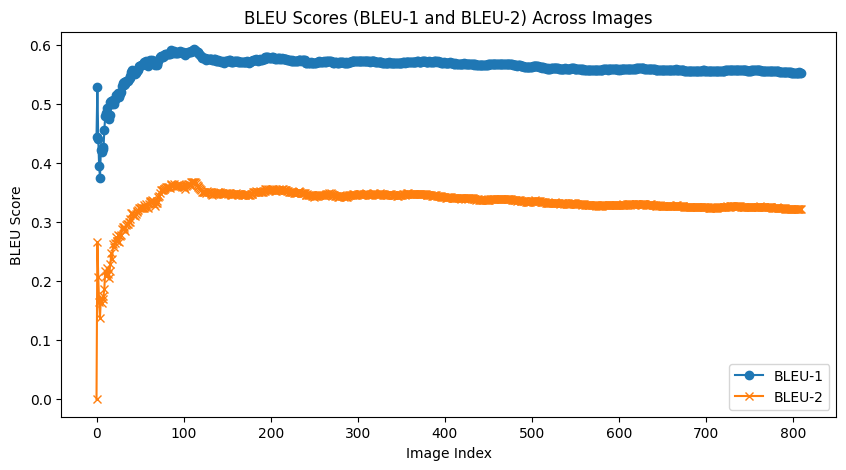

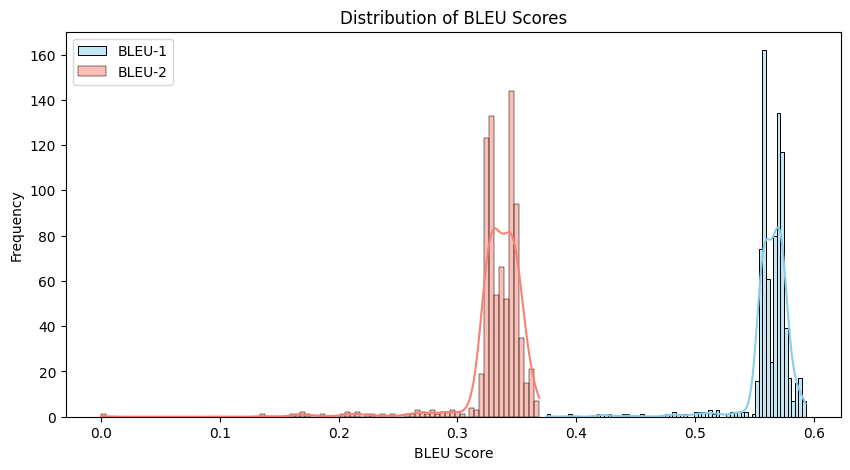

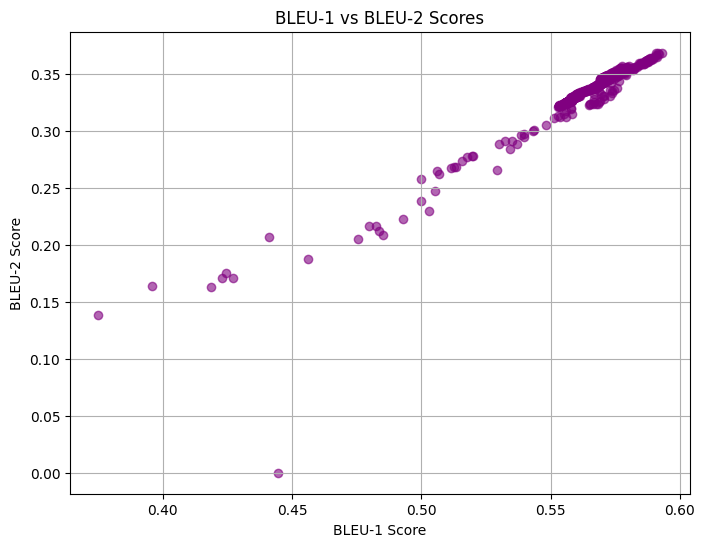

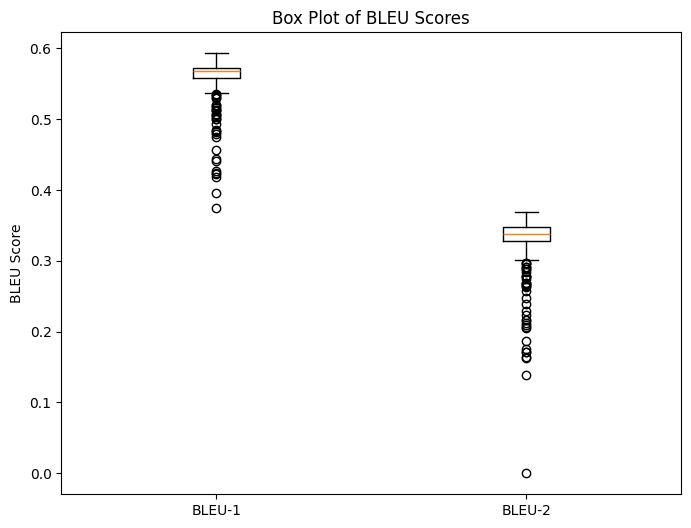

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store BLEU scores
bleu_1_scores = []
bleu_2_scores = []

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual captions for the image
    captions = mapping[key]
    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # Append to the list for BLEU score calculation
    actual.append(actual_captions)
    predicted.append(y_pred)

    # Calculate BLEU-1 and BLEU-2 scores for the current prediction
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

    # Store scores for visualization
    bleu_1_scores.append(bleu_1)
    bleu_2_scores.append(bleu_2)

    # Print BLEU scores for each image
    print("BLEU-1: %f" % bleu_1)
    print("BLEU-2: %f" % bleu_2)



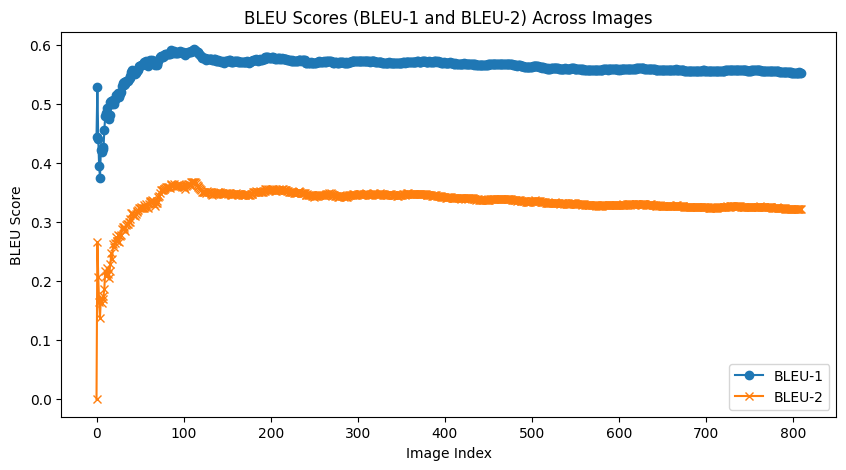

In [ ]:

# Plotting BLEU Scores

# 1. Line plot of BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(bleu_1_scores, label="BLEU-1", marker='o')
plt.plot(bleu_2_scores, label="BLEU-2", marker='x')
plt.xlabel("Image Index")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores (BLEU-1 and BLEU-2) Across Images")
plt.legend()
plt.show()

In [ ]:
# 2. Distribution plot of BLEU scores
plt.figure(figsize=(10, 5))
sns.histplot(bleu_1_scores, color="skyblue", label="BLEU-1", kde=True)
sns.histplot(bleu_2_scores, color="salmon", label="BLEU-2", kde=True)
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.title("Distribution of BLEU Scores")
plt.legend()
plt.show()

In [ ]:
# 3. Scatter plot for BLEU-1 vs BLEU-2 scores
plt.figure(figsize=(8, 6))
plt.scatter(bleu_1_scores, bleu_2_scores, color="purple", alpha=0.6)
plt.xlabel("BLEU-1 Score")
plt.ylabel("BLEU-2 Score")
plt.title("BLEU-1 vs BLEU-2 Scores")
plt.grid(True)
plt.show()

In [ ]:
# 4. Box plot of BLEU scores
plt.figure(figsize=(8, 6))
plt.boxplot([bleu_1_scores, bleu_2_scores], labels=["BLEU-1", "BLEU-2"])
plt.ylabel("BLEU Score")
plt.title("Box Plot of BLEU Scores")
plt.show()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.500000
BLEU-2: 0.196116
BLEU-1: 0.545455
BLEU-2: 0.330289
BLEU-1: 0.515152
BLEU-2: 0.293016
BLEU-1: 0.468085
BLEU-2: 0.233299
BLEU-1: 0.450000
BLEU-2: 0.202260
BLEU-1: 0.452055
BLEU-2: 0.183672
BLEU-1: 0.425287
BLEU-2: 0.163035
BLEU-1: 0.458333
BLEU-2: 0.216506
BLEU-1: 0.478261
BLEU-2: 0.232686
BLEU-1: 0.488000
BLEU-2: 0.243739
BLEU-1: 0.511278
BLEU-2: 0.274653
BLEU-1: 0.510345
BLEU-2: 0.270012
BLEU-1: 0.506579
BLEU-2: 0.263144
BLEU-1: 0.484848
BLEU-2: 0.246997
BLEU-1: 0.463687
BLEU-2: 0.231775
BLEU-1: 0.460733
BLEU-2: 0.235134
BLEU-1: 0.477387
BLEU-2: 0.240221
BLEU-1: 0.492754
BLEU-2: 0.260358
BLEU-1: 0.504587
BLEU-2: 0.271169
BLEU-1: 0.508621
BLEU-2: 0.281375
BLEU-1: 0.500000
BLEU-2: 0.274874
BLEU-1: 0.501931
BLEU-2: 0.276121
BLEU-1: 0.518519
BLEU-2: 0.293377
BLEU-1: 0.519856
BLEU-2: 0.290251
BLEU-1: 0.528169
BLEU-2: 0.299546
BLEU-1: 0.532423
BLEU-2: 0.302867
BLEU-1: 0.526316
BLEU-2: 0.295639
BLEU-1: 0.523810
BLEU-2: 0.292883
BLEU-1: 0.521341
BLEU-2: 0.286269
BLEU-1: 0.5294


Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy bites hard into treat while he sits outside endseq
startseq child biting into baked good endseq
startseq small boy putting something in his mouth with both hands endseq
startseq the boy eats his food outside at the table endseq
startseq the boy is eating pizza over tin dish endseq
--------------------Predicted--------------------
startseq man in blue shirt eats slice of war with his dog endseq


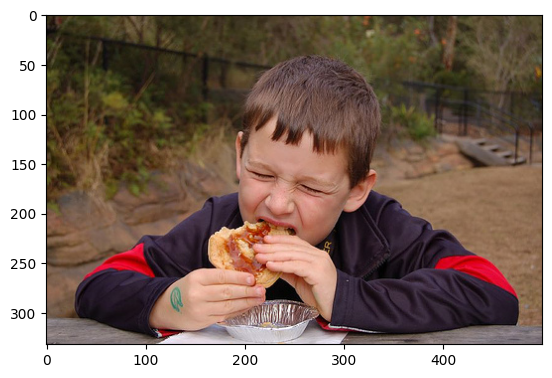

In [ ]:
generate_caption("1034276567_49bb87c51c.jpg")

---------------------Actual---------------------
startseq grey dog beside black and white dog running in green grass endseq
startseq two dogs are wrestling in grassy field endseq
startseq "two dogs playing in field wrestling with each other" endseq
startseq two dogs run along grassy field while one bites the other endseq
startseq two dogs wrestle in field endseq
--------------------Predicted--------------------
startseq black and white dog chases an orange ball endseq


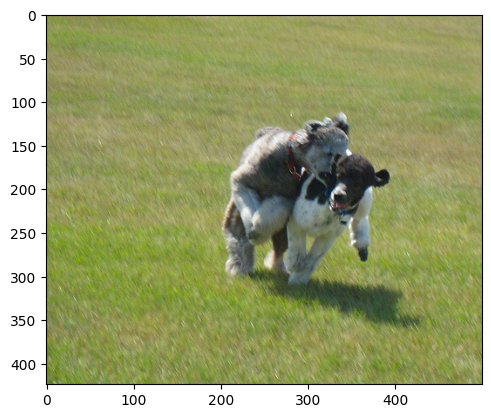

In [ ]:
generate_caption("1164131282_b30926f332.jpg")

---------------------Actual---------------------
startseq brown dog plays in deep pile of snow endseq
startseq dog looking at the camera in snow endseq
startseq dog runs through the snow endseq
startseq tan dog stand in the snow and looks up endseq
startseq the brown dog is out in the snow endseq
--------------------Predicted--------------------
startseq golden retriever is walking in the snow endseq


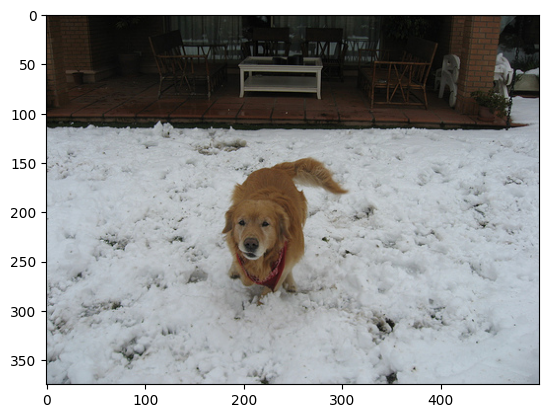

In [ ]:
generate_caption("1094462889_f9966dafa6.jpg")

---------------------Actual---------------------
startseq hiker standing high on bluff overlooking the mountains below endseq
startseq person on ski 's looks from hill over snow covered landscape endseq
startseq skier is overlooking snow-covered mountain endseq
startseq skier is overlooking the beautiful white snow covered landscape endseq
startseq skier pauses on mountaintop endseq
--------------------Predicted--------------------
startseq skier is jumping over snow covered hill endseq


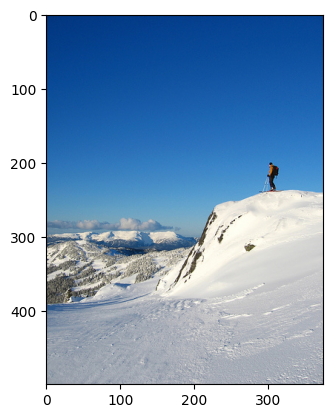

In [ ]:
generate_caption("106514190_bae200f463.jpg")

---------------------Actual---------------------
startseq boy hanging onto pole endseq
startseq kid in green shirt playing in the park endseq
startseq little kid swings on pole at playground endseq
startseq the boy in the green shirt swings with one arm on the silver pole endseq
startseq the boy is swinging on pole at the beach endseq
--------------------Predicted--------------------
startseq boy in blue shirt is jumping over the handrail of playground equipment endseq


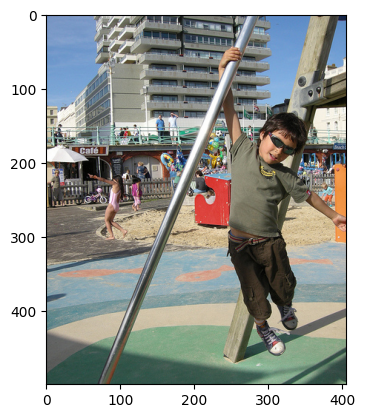

In [ ]:
generate_caption("3759492488_592cd78ed1.jpg")

In [ ]:
image_ids[588]

'1547883892_e29b3db42e'

---------------------Actual---------------------
startseq man in glasses and an asian woman are seated across from each other in subway train endseq
startseq people on subway endseq
startseq people sit inside train endseq
startseq several people sit on train endseq
startseq two men and one woman are sitting in subway train endseq
--------------------Predicted--------------------
startseq two people are sitting on train endseq


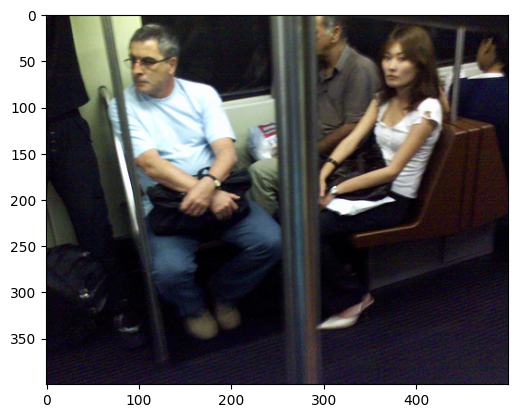

In [ ]:
generate_caption("1332208215_fa824f6659.jpg")

---------------------Actual---------------------
startseq girl is reading while drinking starbuck 's coffee endseq
startseq seated young woman in hat is reading at coffee shop endseq
startseq woman enjoying her reading at coffee shop endseq
startseq woman in hat sits reading and drinking coffee endseq
startseq young woman sips coffee and reads book endseq
--------------------Predicted--------------------
startseq man in black shirt and hat is sitting on bench reading endseq


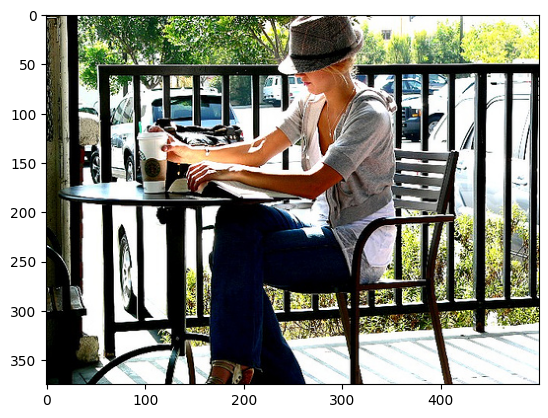

In [ ]:
generate_caption("1547883892_e29b3db42e.jpg")